In [1]:
import numpy as np
import pandas as pd
import re
import time
import torch
import torch.nn as nn
import wandb
import random
import math
import itertools
from transformers import BertTokenizer, BertModel, BertConfig, BertForSequenceClassification, BertPreTrainedModel, Trainer, TrainingArguments
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from kaggle_secrets import UserSecretsClient

In [2]:
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb-key")
wandb.login(key=secret_value_0)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nicost918 (nicost918-petra-christian-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [4]:
data = pd.read_csv('/kaggle/input/doctors-answer-text-dataset/Indo-Online Health Consultation-Medical Interview-Clean.csv', encoding='latin-1')
data.head()

,No,answer,1-FR,2-GI,3-PI,4-DM,5-EDTRB,6-RE,Text_Clean,filtered_text,token,tokens_stemmed,Process_Data
0,1,"Halo Rizal,Radang tenggorokan umunya disebabka...",1,0,1,1,1,0,halo rizal radang tenggorokan umunya disebabka...,halo rizal radang tenggorokan umunya disebabka...,"['halo', 'rizal', 'radang', 'tenggorokan', 'um...","['halo', 'rizal', 'radang', 'tenggorok', 'umu'...",halo rizal radang tenggorok umu sebab infeksi ...
1,2,"Halo Hellas,Cacar air merupakan suatu penyakit...",1,0,1,1,1,0,halo hellas cacar air merupakan suatu penyakit...,halo hellas cacar air penyakit disebabkan viru...,"['halo', 'hellas', 'cacar', 'air', 'penyakit',...","['halo', 'hellas', 'cacar', 'air', 'sakit', 's...",halo hellas cacar air sakit sebab virus varise...
2,3,Halo Rory.......Terimakasih atas pertanyaan An...,1,0,1,1,1,0,halo rory terimakasih atas pertanyaan anda per...,halo rory terimakasih ketahui gangguan kulit s...,"['halo', 'rory', 'terimakasih', 'ketahui', 'ga...","['halo', 'rory', 'terimakasih', 'tahu', 'gangg...",halo rory terimakasih tahu ganggu kulit rangka...
3,4,"Alo AfriYani, Terimakasih atas pertanyaannya. ...",1,0,1,1,1,0,alo afriyani terimakasih atas pertanyaannya ku...,alo afriyani terimakasih pertanyaannya kuku ja...,"['alo', 'afriyani', 'terimakasih', 'pertanyaan...","['alo', 'afriyani', 'terimakasih', 'tanya', 'k...",alo afriyani terimakasih tanya kuku jari kaki ...
4,5,"Halo,Telinga berdenging atau tinitus merupak...",1,0,1,1,1,0,halo telinga berdenging atau tinitus merupakan...,halo telinga berdenging tinitus sensasi penden...,"['halo', 'telinga', 'berdenging', 'tinitus', '...","['halo', 'telinga', 'denging', 'tinitus', 'sen...",halo telinga denging tinitus sensasi dengar de...


In [5]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

labels = data.columns[2:8]
# Extract features and labels for training and validation
X_train = train_data['Text_Clean'].values
y_train = train_data[labels].values
X_val = val_data['Text_Clean'].values
y_val = val_data[labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(400,) (400, 6)
(100,) (100, 6)


In [6]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class DoctorAnswerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
# Define compute metrics for evaluation
def compute_metrics(p):
    preds = torch.sigmoid(torch.tensor(p.predictions)).round()  # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)
    
    accuracy = accuracy_score(labels, preds)

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    a, b, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
    }

In [8]:
# Define compute metrics for evaluation
def compute_metrics_eval(p):
    result = compute_metrics(p)
    
    preds = torch.sigmoid(torch.tensor(p.predictions)).round()  # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)
    
    report = classification_report(
        labels, 
        preds, 
        target_names=['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'],
        zero_division=0
    )    
    return {
        'accuracy': result['accuracy'],
        'precision': result['precision'],
        'recall': result['recall'],
        'f1_micro': result['f1_micro'],
        'f1_macro': result['f1_macro'],
        'report': report
    }

# ACTIVE LEARNING LOOP

In [9]:
accuracies = []
f1_micros = []
f1_macros = []
sampling_dur = []
data_used = []

In [10]:
filename = 'dat-lc'
epochs = 10
batch_size = 8
sequence_length = 256
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 10

In [11]:
def least_confidence_sampling(model, X_pool, train_indices, remaining_indices, trials, n_samples=min_increment):
    start_time = time.time()
    current_train_size = len(train_indices)
        
    dataset = DoctorAnswerDataset(X_pool, np.zeros((len(X_pool), 6)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.eval()
    uncertainties = []
    for data in dataloader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits

        for output in outputs:
            probs = torch.sigmoid(output).cpu().numpy()
            uncertainty = np.absolute(1 - np.max(probs))
            uncertainties.append(uncertainty)

    uncertainties = np.array(uncertainties)
    sorted = np.argsort(uncertainties)
    sorted = sorted[::-1]

    threshold = np.percentile(uncertainties, 90)
    items_greater_than_average = uncertainties[uncertainties >= threshold]
    num_of_candidates = len(items_greater_than_average)

    # Check nearest checkpoint
    nearest_cp = 0
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break
            
    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        least_confident_indices = sorted[:n_samples]
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
         least_confident_indices = sorted[:num_of_candidates]
    else:
        least_confident_indices = sorted[:nearest_cp - current_train_size]

        temp = train_indices.copy()
        temp.extend(least_confident_indices)
        
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            '1-FR': [y_train[i][0] for i in temp],
            '2-GI': [y_train[i][1] for i in temp],
            '3-PI': [y_train[i][2] for i in temp],
            '4-DM': [y_train[i][3] for i in temp],
            '5-EDTRB': [y_train[i][4] for i in temp],
            '6-RE': [y_train[i][5] for i in temp],
        })

        acquired_data.to_csv(f'{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

    end_time = time.time()  # Record the end time
    duration = end_time - start_time  # Calculate the duration in seconds

    print("Nearest checkpoint:", nearest_cp)
    print("Threshold:", threshold)
    print("Samples above threshold:", num_of_candidates)
    print("Acquired samples:", len(least_confident_indices))
    print(f"Sampling duration: {duration} seconds")  # Print or return the runtime if needed
    
    sampling_dur.append(duration)
    
    return [remaining_indices[i] for i in least_confident_indices]

In [12]:
def train_model(current_train_size, train_indices, trials, seed):
    model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p2',
        num_labels=len(labels),
        problem_type="multi_label_classification"
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        # Specify the layers you want to freeze (e.g., first 6 layers)
        if "encoder.layer" in name:
            # Extract the layer number safely
            layer_num = name.split(".")[3]
            try:
                # Freeze only the first 6 layers
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                # Skip any parameter names that don’t follow the expected format
                continue
    
    # Create Dataset with current training data
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_dataset = DoctorAnswerDataset(current_X_train, current_y_train, tokenizer, max_length=sequence_length)
    val_dataset = DoctorAnswerDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    
    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f'./results/{filename}-{trials+1}',
        eval_strategy="epoch",                    # Evaluate after every epoch
        save_strategy="epoch",                    # Save model after every epoch
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='f1_micro',
        save_total_limit=1,
        seed=seed
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    # Train the model
    trainer.train()

    # Evaluate after training
    trainer.compute_metrics = compute_metrics_eval
    eval_results = trainer.evaluate()
    print(f"Iteration {current_train_size}: Accuracy: {eval_results['eval_accuracy']}, F1 Micro: {eval_results['eval_f1_micro']}, F1 Macro: {eval_results['eval_f1_macro']}")
    print(eval_results['eval_report'])

    torch.save(model.state_dict(), f'{filename}-{trials+1}-model.pth')
    model.config.to_json_file(f'{filename}-{trials+1}-config.json')

    data_used.append(current_train_size)
    accuracies.append(eval_results['eval_accuracy'])
    f1_micros.append(eval_results['eval_f1_micro'])
    f1_macros.append(eval_results['eval_f1_macro'])
    
    return model, trainer

In [13]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))

    data_used = [round(data / total_data * 100, 0) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [14]:
def active_learning(seed, i):
    accuracies.clear()
    f1_micros.clear()
    f1_macros.clear()
    sampling_dur.clear()
    data_used.clear()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        model, trainer = train_model(current_train_size, train_indices, i, seed)
    
        # Perform query strategy to select new samples
        new_samples = least_confidence_sampling(
            model, 
            [X_train[i] for i in remaining_indices], 
            train_indices,
            remaining_indices,
            trials=i, 
        )
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    model, trainer = train_model(current_train_size, train_indices, i, seed)
    
    end_time = time.time()
    duration = end_time - start_time  # Calculate the duration in seconds
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    sampling_dur.insert(0, 0)
    
    results['Sampling Duration'] = sampling_dur
    
    results.to_csv(f'{filename}-{i+1}-results.csv', index=False)

In [15]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241230_133612-hnfjmmq0
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./results/dat-lc-1
wandb: ⭐️ View project at https://wandb.ai/nicost918-petra-christian-university/huggingface
wandb: 🚀 View run at https://wandb.ai/nicost918-petra-christian-university/huggingface/runs/hnfjmmq0


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.445599,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.302310,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.249813,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.216971,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.195783,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.184268,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.178531,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.174130,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.171843,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.170646,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 25: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.29817609786987304
Samples above threshold: 38
Acquired samples: 38
Sampling duration: 2.918513059616089 seconds
New train size: 63


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.293727,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.194084,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.164462,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.154726,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.152339,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.146996,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.145237,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.143598,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.142848,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.142645,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 63: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.19387574195861818
Samples above threshold: 34
Acquired samples: 34
Sampling duration: 2.651397943496704 seconds
New train size: 97


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.215272,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.157617,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.144911,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.142079,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.136607,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.135691,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.133534,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.130529,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.130172,0.800000,0.962406,0.979592,0.970923,0.652316
10,No log,0.130433,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 97: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.11037970781326294
Samples above threshold: 31
Acquired samples: 31
Sampling duration: 2.474107503890991 seconds
New train size: 128


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.190550,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.148698,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.140032,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.136462,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.132584,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.132047,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.129206,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.127679,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.130006,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.129192,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 128: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.08869789242744446
Samples above threshold: 28
Acquired samples: 28
Sampling duration: 2.255953073501587 seconds
New train size: 156


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.170274,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.145153,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.138279,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.134007,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.129474,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.126488,0.820000,0.969697,0.979592,0.974619,0.654840
7,No log,0.125115,0.820000,0.972081,0.977041,0.974555,0.654718
8,No log,0.125840,0.820000,0.972081,0.977041,0.974555,0.654718
9,No log,0.124748,0.810000,0.972010,0.974490,0.973248,0.653725
10,No log,0.123434,0.820000,0.976923,0.971939,0.974425,0.654466


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 156: Accuracy: 0.82, F1 Micro: 0.9746192893401016, F1 Macro: 0.6548401347396323
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.017773711681365968
Samples above threshold: 25
Acquired samples: 25
Sampling duration: 2.0589823722839355 seconds
New train size: 181


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.169353,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.142704,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.135097,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.127903,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.123582,0.810000,0.974359,0.969388,0.971867,0.652572
6,No log,0.124930,0.790000,0.974227,0.964286,0.969231,0.650503
7,No log,0.121504,0.820000,0.974425,0.971939,0.973180,0.653588
8,No log,0.126007,0.820000,0.974425,0.971939,0.973180,0.653588
9,No log,0.124809,0.800000,0.974293,0.966837,0.970551,0.651543
10,No log,0.125377,0.810000,0.974359,0.969388,0.971867,0.652572


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.97      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.97      0.96       392
 samples avg       0.97      0.97      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 181: Accuracy: 0.82, F1 Micro: 0.9731800766283526, F1 Macro: 0.6535880911147073
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.97      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.97      0.96       392
 samples avg       0.97      0.97      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.019395601749420167
Samples above threshold: 22
Acquired samples: 22
Sampling duration: 1.903451681137085 seconds
New train size: 203


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.156208,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.140869,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.131304,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.122577,0.840000,0.974555,0.977041,0.975796,0.655587
5,No log,0.117815,0.820000,0.974425,0.971939,0.973180,0.653588
6,No log,0.122107,0.770000,0.974093,0.959184,0.966581,0.648387
7,No log,0.117683,0.800000,0.974293,0.966837,0.970551,0.651543
8,No log,0.117522,0.810000,0.974359,0.969388,0.971867,0.652572
9,No log,0.119287,0.800000,0.974293,0.966837,0.970551,0.651543
10,No log,0.119362,0.810000,0.974359,0.969388,0.971867,0.652572


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 203: Accuracy: 0.84, F1 Micro: 0.975796178343949, F1 Macro: 0.6555870600675632
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.017113041877746583
Samples above threshold: 20
Acquired samples: 20
Sampling duration: 1.7570569515228271 seconds
New train size: 223


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.154612,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.138197,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.129958,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.123640,0.830000,0.974490,0.974490,0.974490,0.654593
5,No log,0.125580,0.800000,0.974293,0.966837,0.970551,0.651543
6,No log,0.124161,0.820000,0.974425,0.971939,0.973180,0.653588
7,No log,0.123672,0.830000,0.974555,0.977041,0.975796,0.655587
8,No log,0.125872,0.820000,0.974425,0.971939,0.973180,0.653588
9,No log,0.125992,0.820000,0.974425,0.971939,0.973180,0.653588
10,No log,0.126174,0.810000,0.971867,0.969388,0.970626,0.652572


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 223: Accuracy: 0.83, F1 Micro: 0.975796178343949, F1 Macro: 0.6555870600675632
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.01595572233200073
Samples above threshold: 18
Acquired samples: 18
Sampling duration: 1.5865681171417236 seconds
New train size: 241


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.151386,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.137761,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.126756,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.118102,0.830000,0.972152,0.979592,0.975858,0.655700
5,No log,0.115852,0.820000,0.972010,0.974490,0.973248,0.653725
6,No log,0.121230,0.840000,0.976982,0.974490,0.975734,0.655471
7,No log,0.118241,0.820000,0.971939,0.971939,0.971939,0.653588
8,No log,0.120374,0.820000,0.974359,0.969388,0.971867,0.653448
9,No log,0.119679,0.810000,0.971867,0.969388,0.970626,0.652572
10,No log,0.120894,0.800000,0.974227,0.964286,0.969231,0.651378


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 241: Accuracy: 0.83, F1 Micro: 0.9758576874205843, F1 Macro: 0.6557002322848127
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.015358233451843261
Samples above threshold: 16
Acquired samples: 9
Sampling duration: 1.4979329109191895 seconds
New train size: 250


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.148534,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134348,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.126028,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.119096,0.830000,0.974490,0.974490,0.974490,0.654593
5,No log,0.125769,0.760000,0.979003,0.951531,0.965071,0.646867
6,No log,0.119345,0.820000,0.972081,0.977041,0.974555,0.654718
7,No log,0.119194,0.820000,0.972081,0.977041,0.974555,0.654718
8,No log,0.119472,0.810000,0.974293,0.966837,0.970551,0.652419
9,No log,0.119574,0.800000,0.969388,0.969388,0.969388,0.651705
10,No log,0.118650,0.790000,0.969309,0.966837,0.968072,0.650678


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 250: Accuracy: 0.82, F1 Micro: 0.9745547073791349, F1 Macro: 0.6547180346175321
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.013475298881530762
Samples above threshold: 15
Acquired samples: 15
Sampling duration: 1.4140806198120117 seconds
New train size: 265


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.147182,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.135362,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.136153,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.119477,0.830000,0.972152,0.979592,0.975858,0.655700
5,No log,0.121043,0.830000,0.972152,0.979592,0.975858,0.655700
6,No log,0.115490,0.820000,0.972010,0.974490,0.973248,0.653725
7,No log,0.119088,0.820000,0.969543,0.974490,0.972010,0.653725
8,No log,0.115518,0.820000,0.974359,0.969388,0.971867,0.653448
9,No log,0.115629,0.800000,0.974227,0.964286,0.969231,0.651378
10,No log,0.115072,0.810000,0.969388,0.969388,0.969388,0.652572


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 265: Accuracy: 0.83, F1 Micro: 0.9758576874205843, F1 Macro: 0.6557002322848127
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.013397216796875
Samples above threshold: 14
Acquired samples: 14
Sampling duration: 1.4103131294250488 seconds
New train size: 279


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.147602,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.132680,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.123883,0.820000,0.969697,0.979592,0.974619,0.654840
4,No log,0.122656,0.790000,0.979167,0.959184,0.969072,0.650143
5,No log,0.118236,0.830000,0.972152,0.979592,0.975858,0.655700
6,No log,0.113058,0.840000,0.976982,0.974490,0.975734,0.655471
7,No log,0.114635,0.820000,0.974359,0.969388,0.971867,0.653448
8,No log,0.114003,0.830000,0.974425,0.971939,0.973180,0.654466
9,No log,0.116102,0.820000,0.974359,0.969388,0.971867,0.707975
10,No log,0.114946,0.830000,0.974425,0.971939,0.973180,0.709004


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 279: Accuracy: 0.83, F1 Micro: 0.9758576874205843, F1 Macro: 0.6557002322848127
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.014171242713928223
Samples above threshold: 13
Acquired samples: 13
Sampling duration: 1.1894993782043457 seconds
New train size: 292


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.148822,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133501,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.123971,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.119775,0.820000,0.967337,0.982143,0.974684,0.654960
5,No log,0.120838,0.770000,0.976501,0.954082,0.965161,0.647972
6,No log,0.120141,0.760000,0.976501,0.954082,0.965161,0.647091
7,No log,0.115228,0.840000,0.974555,0.977041,0.975796,0.749704
8,No log,0.115642,0.820000,0.974425,0.971939,0.973180,0.747657
9,No log,0.118953,0.790000,0.974227,0.964286,0.969231,0.744498
10,No log,0.117868,0.830000,0.974490,0.974490,0.974490,0.748686


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      0.50      0.57         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.74      0.75       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 292: Accuracy: 0.84, F1 Micro: 0.975796178343949, F1 Macro: 0.7497036046031021
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      0.50      0.57         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.74      0.75       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.013069725036621092
Samples above threshold: 11
Acquired samples: 8
Sampling duration: 1.1373751163482666 seconds
New train size: 300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.147452,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134226,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.127588,0.820000,0.969697,0.979592,0.974619,0.654840
4,No log,0.115966,0.820000,0.972081,0.977041,0.974555,0.654718
5,No log,0.116644,0.780000,0.974093,0.959184,0.966581,0.703738
6,No log,0.117452,0.790000,0.974160,0.961735,0.967908,0.743420
7,No log,0.112848,0.850000,0.974619,0.979592,0.977099,0.779466
8,No log,0.110455,0.840000,0.972152,0.979592,0.975858,0.778588
9,No log,0.112490,0.830000,0.974490,0.974490,0.974490,0.777419
10,No log,0.112462,0.840000,0.974555,0.977041,0.975796,0.778448


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.78      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 300: Accuracy: 0.85, F1 Micro: 0.9770992366412214, F1 Macro: 0.7794655093650068
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.78      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 0.012091249227523804
Samples above threshold: 10
Acquired samples: 10
Sampling duration: 1.0320656299591064 seconds
New train size: 310


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145329,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.132309,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.122675,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.111997,0.820000,0.974425,0.971939,0.973180,0.653588
5,No log,0.113218,0.800000,0.976744,0.964286,0.970475,0.760371
6,No log,0.112762,0.840000,0.974555,0.977041,0.975796,0.749704
7,No log,0.116679,0.830000,0.971939,0.971939,0.971939,0.735753
8,No log,0.113192,0.810000,0.974293,0.966837,0.970551,0.745563
9,No log,0.113744,0.830000,0.972010,0.974490,0.973248,0.736782
10,No log,0.112761,0.830000,0.972010,0.974490,0.973248,0.736782


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      0.50      0.57         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.74      0.75       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 310: Accuracy: 0.84, F1 Micro: 0.975796178343949, F1 Macro: 0.7497036046031021
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      0.50      0.57         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.74      0.75       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 0.012304878234863282
Samples above threshold: 9
Acquired samples: 10
Sampling duration: 0.995441198348999 seconds
New train size: 320


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.147124,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.138835,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.125110,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.111677,0.810000,0.976804,0.966837,0.971795,0.652419
5,No log,0.111734,0.850000,0.974684,0.982143,0.978399,0.766698
6,No log,0.106869,0.800000,0.976744,0.964286,0.970475,0.760371
7,No log,0.115710,0.840000,0.972152,0.979592,0.975858,0.765577
8,No log,0.112054,0.820000,0.972010,0.974490,0.973248,0.763530
9,No log,0.110959,0.830000,0.974490,0.974490,0.974490,0.777419
10,No log,0.113878,0.820000,0.972010,0.974490,0.973248,0.763530


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 320: Accuracy: 0.85, F1 Micro: 0.9783989834815755, F1 Macro: 0.7666981711786742
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 0.012635326385498049
Samples above threshold: 8
Acquired samples: 10
Sampling duration: 0.9374797344207764 seconds
New train size: 330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142332,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.136737,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.119973,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.109150,0.840000,0.974619,0.979592,0.977099,0.656570
5,No log,0.112334,0.860000,0.974747,0.984694,0.979695,0.767681
6,No log,0.106906,0.850000,0.972222,0.982143,0.977157,0.779593
7,No log,0.105913,0.860000,0.977157,0.982143,0.979644,0.798328
8,No log,0.107204,0.860000,0.974684,0.982143,0.978399,0.780471
9,No log,0.108371,0.860000,0.974684,0.982143,0.978399,0.780471
10,No log,0.108634,0.860000,0.974684,0.982143,0.978399,0.780471


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 330: Accuracy: 0.86, F1 Micro: 0.9796954314720812, F1 Macro: 0.767680997580495
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 0.011197346448898315
Samples above threshold: 7
Acquired samples: 10
Sampling duration: 0.8336188793182373 seconds
New train size: 340


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145863,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.130101,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.118310,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.110927,0.820000,0.976923,0.971939,0.974425,0.720115
5,No log,0.110428,0.810000,0.976804,0.966837,0.971795,0.761436
6,No log,0.113037,0.850000,0.974619,0.979592,0.977099,0.779466
7,No log,0.110448,0.840000,0.974555,0.977041,0.975796,0.778448
8,No log,0.116522,0.830000,0.972010,0.974490,0.973248,0.763530
9,No log,0.112707,0.830000,0.972010,0.974490,0.973248,0.763530
10,No log,0.110937,0.840000,0.974555,0.977041,0.975796,0.778448


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.78      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 340: Accuracy: 0.85, F1 Micro: 0.9770992366412214, F1 Macro: 0.7794655093650068
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.78      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 0.010423076152801514
Samples above threshold: 6
Acquired samples: 10
Sampling duration: 0.8231520652770996 seconds
New train size: 350


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.151369,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.132593,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.118073,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.122152,0.840000,0.967337,0.982143,0.974684,0.703319
5,No log,0.110149,0.830000,0.974555,0.977041,0.975796,0.721260
6,No log,0.111260,0.850000,0.974619,0.979592,0.977099,0.779466
7,No log,0.124132,0.820000,0.960199,0.984694,0.972292,0.727894
8,No log,0.112856,0.830000,0.972081,0.977041,0.974555,0.764559
9,No log,0.108635,0.840000,0.974555,0.977041,0.975796,0.778448
10,No log,0.109460,0.840000,0.974555,0.977041,0.975796,0.778448


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.78      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 350: Accuracy: 0.85, F1 Micro: 0.9770992366412214, F1 Macro: 0.7794655093650068
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.78      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 0.011387753486633302
Samples above threshold: 5
Acquired samples: 10
Sampling duration: 0.6923737525939941 seconds
New train size: 360


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142991,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133427,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.113543,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.107060,0.850000,0.974619,0.979592,0.977099,0.712021
5,No log,0.109565,0.870000,0.972362,0.987245,0.979747,0.781570
6,No log,0.110659,0.820000,0.971939,0.971939,0.971939,0.762489
7,No log,0.111182,0.820000,0.971939,0.971939,0.971939,0.762489
8,No log,0.112279,0.830000,0.972010,0.974490,0.973248,0.763530
9,No log,0.112148,0.850000,0.972152,0.979592,0.975858,0.765577
10,No log,0.111618,0.840000,0.972081,0.977041,0.974555,0.764559


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 360: Accuracy: 0.87, F1 Micro: 0.979746835443038, F1 Macro: 0.781569886469384
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 0.011099505424499513
Samples above threshold: 4
Acquired samples: 10
Sampling duration: 0.6249372959136963 seconds
New train size: 370


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.146893,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134894,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.119004,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.109965,0.830000,0.974490,0.974490,0.974490,0.654593
5,No log,0.109345,0.820000,0.971867,0.969388,0.970626,0.761436
6,No log,0.114477,0.830000,0.971939,0.971939,0.971939,0.762489
7,No log,0.121641,0.820000,0.962406,0.979592,0.970923,0.731389
8,No log,0.113115,0.820000,0.971867,0.969388,0.970626,0.761436
9,No log,0.113358,0.830000,0.972010,0.974490,0.973248,0.763530
10,No log,0.114205,0.830000,0.972010,0.974490,0.973248,0.763530


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.97      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.97      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 370: Accuracy: 0.83, F1 Micro: 0.9744897959183674, F1 Macro: 0.6545931906724635
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.97      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.97      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 0.011849874258041381
Samples above threshold: 3
Acquired samples: 10
Sampling duration: 0.49704957008361816 seconds
New train size: 380


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.143907,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.130933,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.119310,0.830000,0.969773,0.982143,0.975919,0.655811
4,No log,0.106497,0.820000,0.972081,0.977041,0.974555,0.654718
5,No log,0.102894,0.820000,0.976864,0.969388,0.973111,0.793182
6,No log,0.110641,0.800000,0.971795,0.966837,0.969309,0.760371
7,No log,0.106863,0.860000,0.974747,0.984694,0.979695,0.781466
8,No log,0.107078,0.820000,0.969620,0.977041,0.973316,0.773631
9,No log,0.110858,0.820000,0.969620,0.977041,0.973316,0.773631
10,No log,0.105879,0.840000,0.969773,0.982143,0.975919,0.755471


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 380: Accuracy: 0.86, F1 Micro: 0.9796954314720812, F1 Macro: 0.7814658498484933
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 0.008393144607543946
Samples above threshold: 2
Acquired samples: 10
Sampling duration: 0.4246675968170166 seconds
New train size: 390


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.138638,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133720,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.116503,0.830000,0.974490,0.974490,0.974490,0.654593
4,No log,0.105293,0.830000,0.974555,0.977041,0.975796,0.721260
5,No log,0.104096,0.810000,0.976804,0.966837,0.971795,0.761436
6,No log,0.105055,0.820000,0.976923,0.971939,0.974425,0.794235
7,No log,0.111134,0.810000,0.971939,0.971939,0.971939,0.762489
8,No log,0.104491,0.860000,0.972292,0.984694,0.978454,0.780587
9,No log,0.105482,0.830000,0.974490,0.974490,0.974490,0.777419
10,No log,0.104513,0.850000,0.974619,0.979592,0.977099,0.779466


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 390: Accuracy: 0.86, F1 Micro: 0.9784537389100126, F1 Macro: 0.7805870600675631
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 0.006386524438858033
Samples above threshold: 1
Acquired samples: 10
Sampling duration: 0.3562350273132324 seconds
New train size: 400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.140224,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.131184,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.113909,0.820000,0.972081,0.977041,0.974555,0.654718
4,No log,0.107863,0.840000,0.972222,0.982143,0.977157,0.656672
5,No log,0.105403,0.830000,0.976982,0.974490,0.975734,0.721132
6,No log,0.110870,0.820000,0.971939,0.971939,0.971939,0.762489
7,No log,0.110207,0.850000,0.972292,0.984694,0.978454,0.766811
8,No log,0.107143,0.840000,0.972081,0.977041,0.974555,0.764559
9,No log,0.108641,0.800000,0.971795,0.966837,0.969309,0.733659
10,0.105400,0.109067,0.840000,0.972081,0.977041,0.974555,0.764559


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.75      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 400: Accuracy: 0.85, F1 Micro: 0.9784537389100126, F1 Macro: 0.7668113433959237
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.75      0.77       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.99      0.98       392

Total sampling time: 31.47 seconds
Total runtime: 2698.7663860321045 seconds


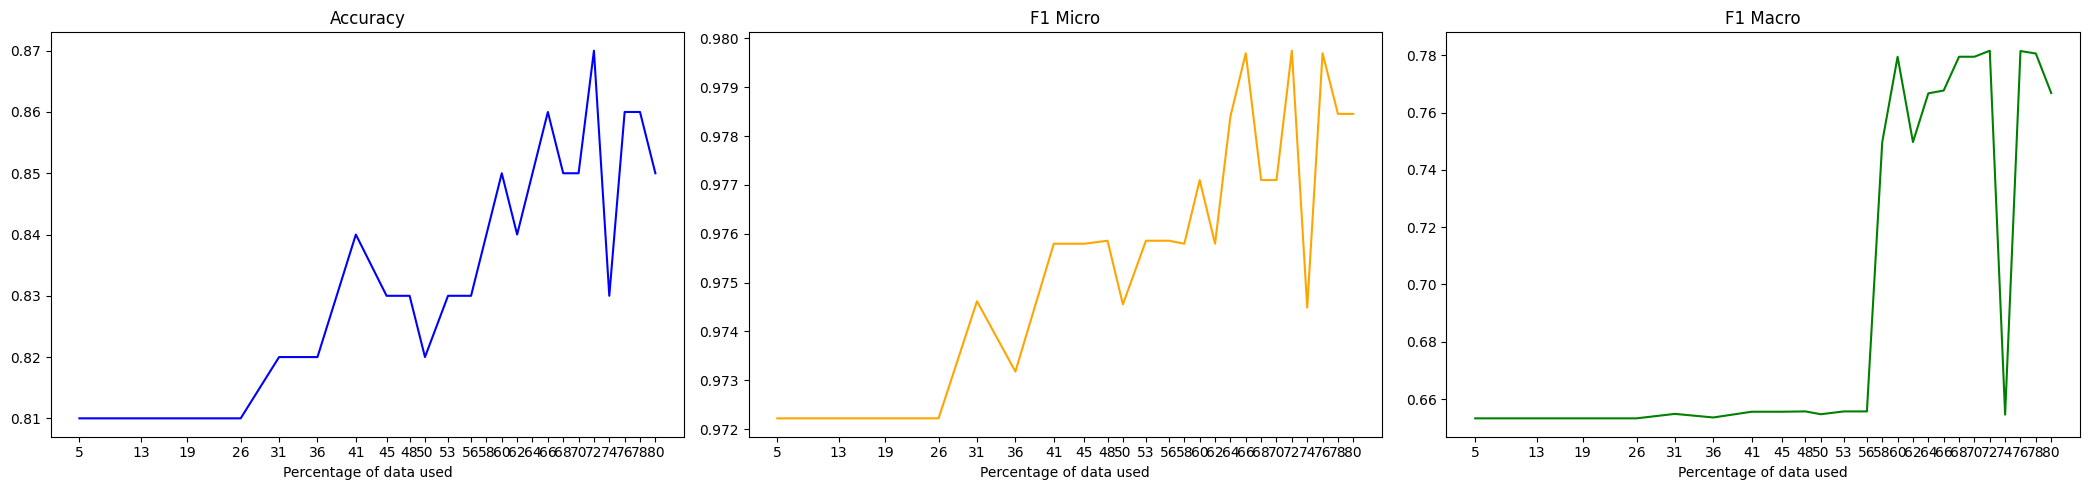

In [16]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.427260,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.301268,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.235869,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.204235,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.186607,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.177279,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.172513,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.168742,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.166898,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.166246,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 25: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.3206903696060181
Samples above threshold: 38
Acquired samples: 38
Sampling duration: 2.997556209564209 seconds
New train size: 63


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.251333,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.176708,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.160470,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.149294,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.144442,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.141616,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.140124,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.139291,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.138546,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.138213,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 63: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.1634088158607483
Samples above threshold: 34
Acquired samples: 34
Sampling duration: 2.7395663261413574 seconds
New train size: 97


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.193248,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.152138,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.141946,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.137265,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.135057,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.132365,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.129784,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.128559,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.127368,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.126918,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 97: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.09873770475387574
Samples above threshold: 31
Acquired samples: 31
Sampling duration: 2.467522382736206 seconds
New train size: 128


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.176749,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.146013,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.137937,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.134058,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.130418,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.125851,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.122261,0.820000,0.964912,0.982143,0.973451,0.654117
8,No log,0.120026,0.830000,0.967337,0.982143,0.974684,0.654960
9,No log,0.119167,0.830000,0.969773,0.982143,0.975919,0.655811
10,No log,0.119016,0.830000,0.972152,0.979592,0.975858,0.655700


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      1.00      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 128: Accuracy: 0.83, F1 Micro: 0.9759188846641319, F1 Macro: 0.6558109307923955
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      1.00      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.021538913249969482
Samples above threshold: 28
Acquired samples: 28
Sampling duration: 2.374624013900757 seconds
New train size: 156


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.163987,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.141286,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.133702,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.126097,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.126506,0.810000,0.974425,0.971939,0.973180,0.653588
6,No log,0.119281,0.840000,0.974619,0.979592,0.977099,0.656570
7,No log,0.118510,0.850000,0.974684,0.982143,0.978399,0.657542
8,No log,0.119672,0.830000,0.967337,0.982143,0.974684,0.654960
9,No log,0.117345,0.820000,0.974490,0.974490,0.974490,0.654593
10,No log,0.117395,0.820000,0.974490,0.974490,0.974490,0.654593


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 156: Accuracy: 0.85, F1 Micro: 0.9783989834815755, F1 Macro: 0.6575418529109637
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.01878281831741333
Samples above threshold: 25
Acquired samples: 25
Sampling duration: 2.1799750328063965 seconds
New train size: 181


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.154281,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.138031,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.128525,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.122910,0.830000,0.967337,0.982143,0.974684,0.654960
5,No log,0.116600,0.840000,0.972152,0.979592,0.975858,0.655700
6,No log,0.116120,0.830000,0.974555,0.977041,0.975796,0.655587
7,No log,0.116871,0.810000,0.974425,0.971939,0.973180,0.653588
8,No log,0.117114,0.810000,0.976864,0.969388,0.973111,0.653448
9,No log,0.116519,0.820000,0.974490,0.974490,0.974490,0.654593
10,No log,0.116373,0.810000,0.974425,0.971939,0.973180,0.653588


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 181: Accuracy: 0.84, F1 Micro: 0.9758576874205843, F1 Macro: 0.6557002322848127
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.01773456335067749
Samples above threshold: 22
Acquired samples: 22
Sampling duration: 1.9440007209777832 seconds
New train size: 203


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.150681,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134151,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.125738,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.119739,0.790000,0.976744,0.964286,0.970475,0.651378
5,No log,0.114127,0.830000,0.976982,0.974490,0.975734,0.655471
6,No log,0.114699,0.820000,0.972081,0.977041,0.974555,0.654718
7,No log,0.114917,0.820000,0.976923,0.971939,0.974425,0.654466
8,No log,0.114286,0.830000,0.979434,0.971939,0.975672,0.655353
9,No log,0.114741,0.840000,0.979487,0.974490,0.976982,0.656359
10,No log,0.114587,0.830000,0.976982,0.974490,0.975734,0.655471


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.97      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.97      0.97       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 203: Accuracy: 0.84, F1 Micro: 0.9769820971867007, F1 Macro: 0.6563594487589463
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.97      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.97      0.97       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.01347801685333252
Samples above threshold: 20
Acquired samples: 20
Sampling duration: 1.7494447231292725 seconds
New train size: 223


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.148445,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133835,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.123800,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.116952,0.830000,0.969697,0.979592,0.974619,0.654840
5,No log,0.117792,0.800000,0.976744,0.964286,0.970475,0.651378
6,No log,0.115827,0.820000,0.974425,0.971939,0.973180,0.653588
7,No log,0.118855,0.780000,0.974160,0.961735,0.967908,0.649451
8,No log,0.116375,0.810000,0.971939,0.971939,0.971939,0.653588
9,No log,0.115642,0.800000,0.974293,0.966837,0.970551,0.651543
10,No log,0.115140,0.820000,0.972010,0.974490,0.973248,0.653725


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 223: Accuracy: 0.83, F1 Micro: 0.9746835443037974, F1 Macro: 0.6549595805112519
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.017852747440338136
Samples above threshold: 18
Acquired samples: 18
Sampling duration: 1.5661208629608154 seconds
New train size: 241


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.147044,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133094,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.121348,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.119041,0.820000,0.967254,0.979592,0.973384,0.653989
5,No log,0.117453,0.830000,0.969697,0.979592,0.974619,0.654840
6,No log,0.117459,0.810000,0.979328,0.966837,0.973042,0.653305
7,No log,0.113988,0.830000,0.972081,0.977041,0.974555,0.654718
8,No log,0.111723,0.810000,0.969543,0.974490,0.972010,0.652866
9,No log,0.112891,0.820000,0.972010,0.974490,0.973248,0.653725
10,No log,0.112370,0.800000,0.974359,0.969388,0.971867,0.652572


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 241: Accuracy: 0.83, F1 Micro: 0.9746192893401016, F1 Macro: 0.6548401347396323
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.018413543701171875
Samples above threshold: 16
Acquired samples: 9
Sampling duration: 1.5126171112060547 seconds
New train size: 250


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.147415,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133015,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.128444,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.119286,0.800000,0.969466,0.971939,0.970701,0.651863
5,No log,0.116228,0.810000,0.969543,0.974490,0.972010,0.652866
6,No log,0.122200,0.780000,0.979167,0.959184,0.969072,0.650143
7,No log,0.119461,0.820000,0.967254,0.979592,0.973384,0.653989
8,No log,0.114138,0.780000,0.974227,0.964286,0.969231,0.650503
9,No log,0.113874,0.780000,0.974227,0.964286,0.969231,0.650503
10,No log,0.113648,0.800000,0.974359,0.969388,0.971867,0.652572


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 250: Accuracy: 0.83, F1 Micro: 0.9746835443037974, F1 Macro: 0.6549595805112519
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.01671473979949951
Samples above threshold: 15
Acquired samples: 15
Sampling duration: 1.3968837261199951 seconds
New train size: 265


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145196,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.135435,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.133262,0.820000,0.969620,0.977041,0.973316,0.653859
4,No log,0.128863,0.770000,0.984211,0.954082,0.968912,0.649765
5,No log,0.115281,0.820000,0.969620,0.977041,0.973316,0.653859
6,No log,0.115291,0.800000,0.969466,0.971939,0.970701,0.651863
7,No log,0.114342,0.760000,0.969152,0.961735,0.965429,0.647734
8,No log,0.110580,0.790000,0.969388,0.969388,0.969388,0.650848
9,No log,0.110127,0.780000,0.969309,0.966837,0.968072,0.649822
10,No log,0.110426,0.780000,0.969309,0.966837,0.968072,0.649822


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 265: Accuracy: 0.82, F1 Micro: 0.9733163913595934, F1 Macro: 0.6538586116586617
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.022288000583648684
Samples above threshold: 14
Acquired samples: 14
Sampling duration: 1.2957265377044678 seconds
New train size: 279


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145576,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.137087,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.120668,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.110499,0.840000,0.972222,0.982143,0.977157,0.656672
5,No log,0.111713,0.800000,0.971939,0.971939,0.971939,0.652721
6,No log,0.108796,0.820000,0.972081,0.977041,0.974555,0.654718
7,No log,0.112825,0.790000,0.981771,0.961735,0.971649,0.652104
8,No log,0.109743,0.790000,0.969388,0.969388,0.969388,0.651705
9,No log,0.110712,0.790000,0.969388,0.969388,0.969388,0.651705
10,No log,0.110178,0.790000,0.971795,0.966837,0.969309,0.651543


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 279: Accuracy: 0.84, F1 Micro: 0.9771573604060914, F1 Macro: 0.6566716365711341
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.015537261962890625
Samples above threshold: 13
Acquired samples: 13
Sampling duration: 1.193211317062378 seconds
New train size: 292


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.141623,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.131114,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.123578,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.111510,0.830000,0.967337,0.982143,0.974684,0.654960
5,No log,0.112537,0.790000,0.981771,0.961735,0.971649,0.652104
6,No log,0.107085,0.820000,0.969620,0.977041,0.973316,0.653859
7,No log,0.108754,0.780000,0.979221,0.961735,0.970399,0.651209
8,No log,0.106293,0.800000,0.967005,0.971939,0.969466,0.706403
9,No log,0.105178,0.800000,0.967005,0.971939,0.969466,0.651863
10,No log,0.105362,0.780000,0.966837,0.966837,0.966837,0.649822


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 292: Accuracy: 0.83, F1 Micro: 0.9746835443037974, F1 Macro: 0.6549595805112519
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.01752764582633972
Samples above threshold: 11
Acquired samples: 8
Sampling duration: 1.1174306869506836 seconds
New train size: 300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.140575,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.129500,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.122370,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.112137,0.800000,0.967089,0.974490,0.970775,0.652017
5,No log,0.108303,0.790000,0.974293,0.966837,0.970551,0.717170
6,No log,0.113390,0.830000,0.967337,0.982143,0.974684,0.720656
7,No log,0.106030,0.810000,0.967172,0.977041,0.972081,0.718684
8,No log,0.109877,0.800000,0.962312,0.977041,0.969620,0.699636
9,No log,0.109513,0.800000,0.962312,0.977041,0.969620,0.699636
10,No log,0.107993,0.800000,0.964646,0.974490,0.969543,0.699482


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 300: Accuracy: 0.83, F1 Micro: 0.9746835443037974, F1 Macro: 0.6549595805112519
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 0.021535289287567143
Samples above threshold: 10
Acquired samples: 10
Sampling duration: 1.0929789543151855 seconds
New train size: 310


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.146468,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134176,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.122228,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.111433,0.830000,0.967337,0.982143,0.974684,0.654960
5,No log,0.107714,0.820000,0.972081,0.977041,0.974555,0.654718
6,No log,0.106042,0.830000,0.974555,0.977041,0.975796,0.655587
7,No log,0.107060,0.810000,0.974425,0.971939,0.973180,0.719238
8,No log,0.108667,0.820000,0.974490,0.974490,0.974490,0.720255
9,No log,0.107528,0.800000,0.967089,0.974490,0.970775,0.700340
10,No log,0.107188,0.810000,0.969543,0.974490,0.972010,0.701207


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 310: Accuracy: 0.83, F1 Micro: 0.975796178343949, F1 Macro: 0.6555870600675632
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 0.013739401102066043
Samples above threshold: 9
Acquired samples: 10
Sampling duration: 1.0176470279693604 seconds
New train size: 320


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.140966,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.127381,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.122594,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.117333,0.840000,0.969773,0.982143,0.975919,0.721507
5,No log,0.103593,0.830000,0.974555,0.977041,0.975796,0.721260
6,No log,0.107027,0.780000,0.976744,0.964286,0.970475,0.716992
7,No log,0.105180,0.800000,0.976864,0.969388,0.973111,0.762489
8,No log,0.102143,0.790000,0.976804,0.966837,0.971795,0.718045
9,No log,0.102654,0.820000,0.969620,0.977041,0.973316,0.719533
10,No log,0.102683,0.800000,0.971867,0.969388,0.970626,0.717344


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.71      0.72       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 320: Accuracy: 0.84, F1 Micro: 0.9759188846641319, F1 Macro: 0.7215068014062989
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.71      0.72       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 0.015722167491912842
Samples above threshold: 8
Acquired samples: 10
Sampling duration: 0.8997070789337158 seconds
New train size: 330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.146079,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.129667,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.118253,0.840000,0.974619,0.979592,0.977099,0.656570
4,No log,0.111485,0.830000,0.967337,0.982143,0.974684,0.654960
5,No log,0.108692,0.830000,0.967337,0.982143,0.974684,0.720656
6,No log,0.106389,0.810000,0.972010,0.974490,0.973248,0.719387
7,No log,0.104412,0.820000,0.972081,0.977041,0.974555,0.720392
8,No log,0.105629,0.790000,0.969466,0.971939,0.970701,0.707260
9,No log,0.103660,0.800000,0.971939,0.971939,0.971939,0.718372
10,No log,0.104698,0.790000,0.969466,0.971939,0.970701,0.707260


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 330: Accuracy: 0.84, F1 Micro: 0.9770992366412214, F1 Macro: 0.656569886469384
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 0.013534015417099
Samples above threshold: 7
Acquired samples: 10
Sampling duration: 0.8883423805236816 seconds
New train size: 340


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.138371,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.129007,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.116466,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.108977,0.830000,0.974555,0.977041,0.975796,0.655587
5,No log,0.107223,0.810000,0.972010,0.974490,0.973248,0.653725
6,No log,0.108524,0.840000,0.974619,0.979592,0.977099,0.722254
7,No log,0.111680,0.810000,0.969543,0.974490,0.972010,0.735905
8,No log,0.110570,0.790000,0.969388,0.969388,0.969388,0.699162
9,No log,0.109526,0.790000,0.971867,0.969388,0.970626,0.707099
10,No log,0.109112,0.790000,0.969388,0.969388,0.969388,0.699162


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.70      0.72       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 340: Accuracy: 0.84, F1 Micro: 0.9770992366412214, F1 Macro: 0.7222537267342298
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.70      0.72       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 0.00909806489944458
Samples above threshold: 6
Acquired samples: 10
Sampling duration: 0.7810978889465332 seconds
New train size: 350


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.140501,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133656,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.115882,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.114009,0.800000,0.976804,0.966837,0.971795,0.718045
5,No log,0.107980,0.840000,0.969773,0.982143,0.975919,0.721507
6,No log,0.107499,0.820000,0.976923,0.971939,0.974425,0.720115
7,No log,0.107965,0.830000,0.969697,0.979592,0.974619,0.720525
8,No log,0.110114,0.800000,0.979275,0.964286,0.971722,0.717876
9,No log,0.108776,0.810000,0.974425,0.971939,0.973180,0.709004
10,No log,0.108533,0.810000,0.974425,0.971939,0.973180,0.709004


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.71      0.72       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 350: Accuracy: 0.84, F1 Micro: 0.9759188846641319, F1 Macro: 0.7215068014062989
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.71      0.72       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 0.01014101505279541
Samples above threshold: 5
Acquired samples: 10
Sampling duration: 0.7177188396453857 seconds
New train size: 360


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.141709,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.131718,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.116762,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.108838,0.820000,0.972081,0.977041,0.974555,0.654718
5,No log,0.111044,0.780000,0.976684,0.961735,0.969152,0.650325
6,No log,0.108381,0.800000,0.969543,0.974490,0.972010,0.735905
7,No log,0.109286,0.810000,0.974425,0.971939,0.973180,0.719238
8,No log,0.107955,0.800000,0.971939,0.971939,0.971939,0.708127
9,No log,0.107899,0.800000,0.971939,0.971939,0.971939,0.708127
10,No log,0.107889,0.790000,0.969466,0.971939,0.970701,0.707260


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 360: Accuracy: 0.82, F1 Micro: 0.9745547073791349, F1 Macro: 0.6547180346175321
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 0.012752139568328857
Samples above threshold: 4
Acquired samples: 10
Sampling duration: 0.6229448318481445 seconds
New train size: 370


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.141553,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.126731,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.115715,0.840000,0.969773,0.982143,0.975919,0.655811
4,No log,0.106989,0.850000,0.972222,0.982143,0.977157,0.722367
5,No log,0.109000,0.820000,0.972081,0.977041,0.974555,0.764559
6,No log,0.111638,0.820000,0.969620,0.977041,0.973316,0.763683
7,No log,0.103833,0.820000,0.972010,0.974490,0.973248,0.719387
8,No log,0.103796,0.830000,0.967254,0.979592,0.973384,0.763832
9,No log,0.102853,0.830000,0.967254,0.979592,0.973384,0.737058
10,No log,0.102617,0.850000,0.967419,0.984694,0.975980,0.765829


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.71      0.72       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 370: Accuracy: 0.85, F1 Micro: 0.9771573604060914, F1 Macro: 0.7223668989514792
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.71      0.72       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 0.010761231184005737
Samples above threshold: 3
Acquired samples: 10
Sampling duration: 0.5060057640075684 seconds
New train size: 380


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.139870,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.129339,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.111676,0.850000,0.974684,0.982143,0.978399,0.657542
4,No log,0.107345,0.810000,0.979381,0.969388,0.974359,0.654335
5,No log,0.108100,0.810000,0.974425,0.971939,0.973180,0.747657
6,No log,0.104134,0.850000,0.972292,0.984694,0.978454,0.780587
7,No log,0.109169,0.820000,0.976923,0.971939,0.974425,0.777263
8,No log,0.107294,0.830000,0.972152,0.979592,0.975858,0.778588
9,No log,0.108300,0.850000,0.977099,0.979592,0.978344,0.780353
10,No log,0.107214,0.830000,0.972152,0.979592,0.975858,0.778588


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 380: Accuracy: 0.85, F1 Micro: 0.9784537389100126, F1 Macro: 0.7805870600675631
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 0.007201093435287476
Samples above threshold: 2
Acquired samples: 10
Sampling duration: 0.4303562641143799 seconds
New train size: 390


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.139221,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.130695,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.126312,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.106222,0.810000,0.979328,0.966837,0.973042,0.653305
5,No log,0.106623,0.810000,0.974425,0.971939,0.973180,0.793361
6,No log,0.103945,0.830000,0.976982,0.974490,0.975734,0.764559
7,No log,0.104013,0.820000,0.969620,0.977041,0.973316,0.763683
8,No log,0.107528,0.830000,0.972081,0.977041,0.974555,0.764559
9,No log,0.102618,0.830000,0.969697,0.979592,0.974619,0.764699
10,No log,0.101505,0.840000,0.972152,0.979592,0.975858,0.778588


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.78      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 390: Accuracy: 0.84, F1 Micro: 0.9758576874205843, F1 Macro: 0.7785880911147073
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.78      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 0.006242531538009644
Samples above threshold: 1
Acquired samples: 10
Sampling duration: 0.33769965171813965 seconds
New train size: 400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.141736,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.130197,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.111935,0.840000,0.972222,0.982143,0.977157,0.656672
4,No log,0.105637,0.840000,0.972222,0.982143,0.977157,0.722367
5,No log,0.099823,0.840000,0.974555,0.977041,0.975796,0.778448
6,No log,0.102290,0.860000,0.972292,0.984694,0.978454,0.780587
7,No log,0.101612,0.850000,0.972222,0.982143,0.977157,0.779593
8,No log,0.099887,0.850000,0.977041,0.977041,0.977041,0.779335
9,No log,0.101075,0.830000,0.969697,0.979592,0.974619,0.764699
10,0.101300,0.099971,0.850000,0.972222,0.982143,0.977157,0.779593


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 400: Accuracy: 0.86, F1 Micro: 0.9784537389100126, F1 Macro: 0.7805870600675631
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392

Total sampling time: 31.83 seconds
Total runtime: 2670.1910305023193 seconds


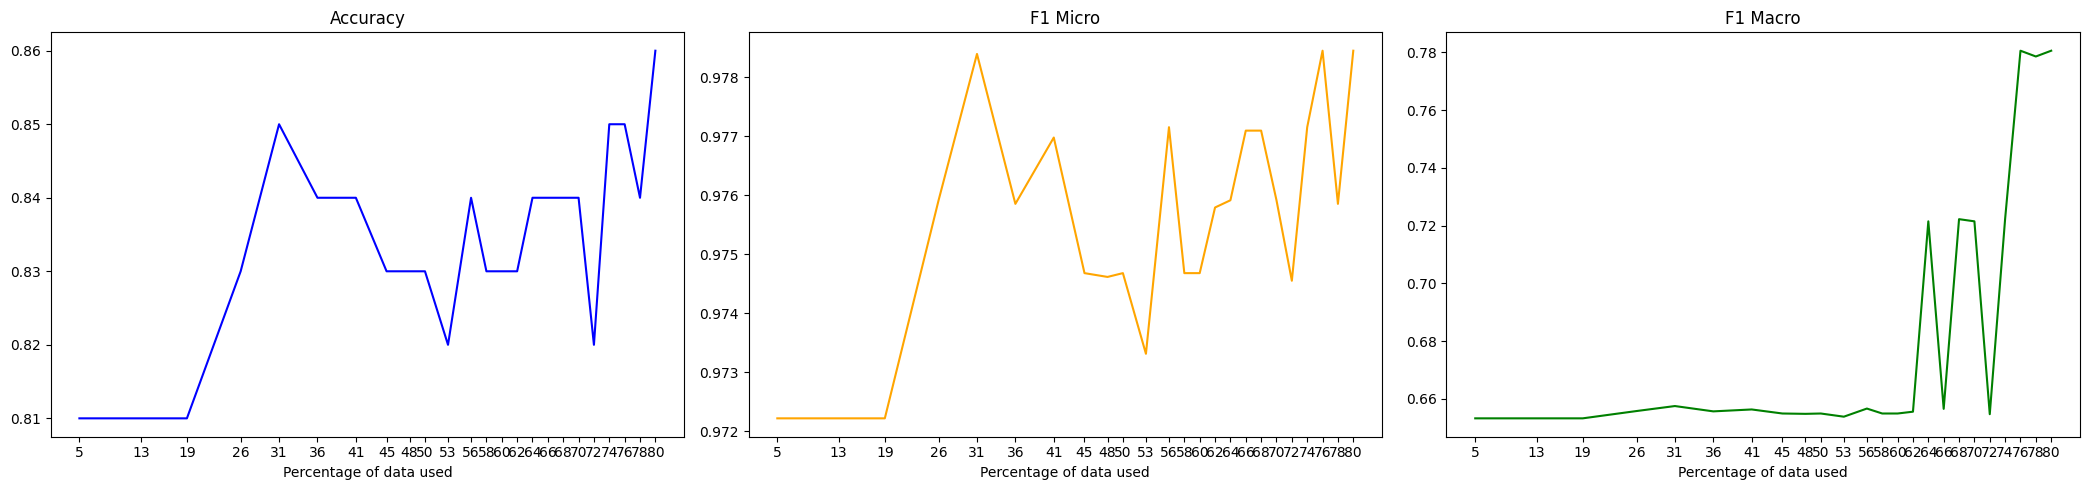

In [17]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.397611,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.288708,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.231498,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.205215,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.187409,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.178176,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.173865,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.169992,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.167555,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.166610,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 25: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.286108660697937
Samples above threshold: 38
Acquired samples: 38
Sampling duration: 2.9436824321746826 seconds
New train size: 63


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.274766,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.192287,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.165002,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.153490,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.148375,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.146169,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.143690,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.142717,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.141640,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.141371,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 63: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.14771941900253296
Samples above threshold: 34
Acquired samples: 34
Sampling duration: 2.7099616527557373 seconds
New train size: 97


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.197567,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.157128,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.146263,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.143132,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.139643,0.800000,0.962406,0.979592,0.970923,0.652316
6,No log,0.138422,0.800000,0.962406,0.979592,0.970923,0.652316
7,No log,0.136325,0.800000,0.962406,0.979592,0.970923,0.652316
8,No log,0.135952,0.780000,0.962217,0.974490,0.968314,0.650346
9,No log,0.135402,0.790000,0.962312,0.977041,0.969620,0.651336
10,No log,0.135315,0.780000,0.962217,0.974490,0.968314,0.650346


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 97: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.09393216371536255
Samples above threshold: 31
Acquired samples: 31
Sampling duration: 2.494767427444458 seconds
New train size: 128


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.184146,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.148718,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.139968,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.139162,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.135328,0.800000,0.962406,0.979592,0.970923,0.652316
6,No log,0.133534,0.800000,0.964736,0.977041,0.970849,0.652168
7,No log,0.131118,0.800000,0.962406,0.979592,0.970923,0.652316
8,No log,0.130268,0.800000,0.964646,0.974490,0.969543,0.651177
9,No log,0.128928,0.810000,0.964824,0.979592,0.972152,0.653148
10,No log,0.128878,0.820000,0.967254,0.979592,0.973384,0.653989


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.66      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 128: Accuracy: 0.82, F1 Micro: 0.973384030418251, F1 Macro: 0.6539894371676231
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.66      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.02049270272254944
Samples above threshold: 28
Acquired samples: 28
Sampling duration: 2.280712604522705 seconds
New train size: 156


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.165057,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.144684,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.145524,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.139240,0.790000,0.962312,0.977041,0.969620,0.651336
5,No log,0.146772,0.740000,0.966495,0.956633,0.961538,0.644756
6,No log,0.130309,0.800000,0.964646,0.974490,0.969543,0.651177
7,No log,0.126654,0.800000,0.964736,0.977041,0.970849,0.652168
8,No log,0.128500,0.790000,0.966921,0.969388,0.968153,0.650000
9,No log,0.124321,0.800000,0.964736,0.977041,0.970849,0.652168
10,No log,0.123539,0.810000,0.967172,0.977041,0.972081,0.653009


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 156: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.06229330897331238
Samples above threshold: 25
Acquired samples: 25
Sampling duration: 2.100957155227661 seconds
New train size: 181


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.164491,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.142809,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.135762,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.128909,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.129473,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.117954,0.830000,0.972081,0.977041,0.974555,0.654718
7,No log,0.116069,0.820000,0.969620,0.977041,0.973316,0.653859
8,No log,0.116472,0.820000,0.976923,0.971939,0.974425,0.654466
9,No log,0.115631,0.820000,0.976923,0.971939,0.974425,0.654466
10,No log,0.114985,0.820000,0.976923,0.971939,0.974425,0.654466


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 181: Accuracy: 0.83, F1 Micro: 0.9745547073791349, F1 Macro: 0.6547180346175321
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.65      0.66      0.65       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.01669019460678101
Samples above threshold: 22
Acquired samples: 22
Sampling duration: 1.9338231086730957 seconds
New train size: 203


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.156478,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.137250,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.127674,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.122169,0.830000,0.974555,0.977041,0.975796,0.655587
5,No log,0.119598,0.810000,0.979275,0.964286,0.971722,0.652263
6,No log,0.118249,0.840000,0.972152,0.979592,0.975858,0.655700
7,No log,0.117511,0.840000,0.972152,0.979592,0.975858,0.655700
8,No log,0.116427,0.830000,0.972081,0.977041,0.974555,0.654718
9,No log,0.115993,0.850000,0.977041,0.977041,0.977041,0.657355
10,No log,0.115488,0.850000,0.979540,0.977041,0.978289,0.657355


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 203: Accuracy: 0.85, F1 Micro: 0.9782886334610472, F1 Macro: 0.6573545694574568
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.65      0.66      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.015559113025665284
Samples above threshold: 20
Acquired samples: 20
Sampling duration: 1.7379639148712158 seconds
New train size: 223


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.153325,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.138894,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.126722,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.115858,0.840000,0.969773,0.982143,0.975919,0.655811
5,No log,0.114991,0.820000,0.972010,0.974490,0.973248,0.653725
6,No log,0.111921,0.810000,0.976864,0.969388,0.973111,0.653448
7,No log,0.109758,0.830000,0.969620,0.977041,0.973316,0.654718
8,No log,0.108239,0.810000,0.971939,0.971939,0.971939,0.653588
9,No log,0.106686,0.820000,0.972010,0.974490,0.973248,0.709144
10,No log,0.107359,0.830000,0.974490,0.974490,0.974490,0.710021


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      1.00      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 223: Accuracy: 0.84, F1 Micro: 0.9759188846641319, F1 Macro: 0.6558109307923955
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      1.00      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.01694365739822388
Samples above threshold: 18
Acquired samples: 18
Sampling duration: 1.6408147811889648 seconds
New train size: 241


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.150920,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.137837,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.130956,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.120857,0.810000,0.976864,0.969388,0.973111,0.653448
5,No log,0.113334,0.820000,0.972081,0.977041,0.974555,0.654718
6,No log,0.115623,0.830000,0.967254,0.979592,0.973384,0.654840
7,No log,0.108269,0.830000,0.972081,0.977041,0.974555,0.748826
8,No log,0.107400,0.830000,0.976982,0.974490,0.975734,0.749573
9,No log,0.108142,0.830000,0.972081,0.977041,0.974555,0.748826
10,No log,0.106492,0.830000,0.972081,0.977041,0.974555,0.748826


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      0.50      0.57         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.94      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.97      0.98       392
   macro avg       0.76      0.74      0.75       392
weighted avg       0.97      0.97      0.97       392
 samples avg       0.98      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 241: Accuracy: 0.83, F1 Micro: 0.9757343550446999, F1 Macro: 0.7495729880931753
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      0.50      0.57         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.94      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.97      0.98       392
   macro avg       0.76      0.74      0.75       392
weighted avg       0.97      0.97      0.97       392
 samples avg       0.98      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.013490998744964601
Samples above threshold: 16
Acquired samples: 9
Sampling duration: 1.4888410568237305 seconds
New train size: 250


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.150454,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.136742,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.122003,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.116366,0.810000,0.974425,0.971939,0.973180,0.653588
5,No log,0.110622,0.830000,0.969697,0.979592,0.974619,0.654840
6,No log,0.106163,0.840000,0.976982,0.974490,0.975734,0.749573
7,No log,0.103764,0.820000,0.972010,0.974490,0.973248,0.747810
8,No log,0.102786,0.840000,0.972152,0.979592,0.975858,0.778588
9,No log,0.103631,0.850000,0.974619,0.979592,0.977099,0.779466
10,No log,0.102609,0.860000,0.972292,0.984694,0.978454,0.780587


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 250: Accuracy: 0.86, F1 Micro: 0.9784537389100126, F1 Macro: 0.7805870600675631
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.012236851453781127
Samples above threshold: 15
Acquired samples: 15
Sampling duration: 1.4364254474639893 seconds
New train size: 265


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.146688,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134217,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.119537,0.840000,0.969773,0.982143,0.975919,0.655811
4,No log,0.111757,0.840000,0.977041,0.977041,0.977041,0.656466
5,No log,0.104988,0.860000,0.969925,0.987245,0.978508,0.780700
6,No log,0.104129,0.860000,0.974684,0.982143,0.978399,0.802614
7,No log,0.103470,0.860000,0.977099,0.979592,0.978344,0.802483
8,No log,0.104889,0.850000,0.974619,0.979592,0.977099,0.801596
9,No log,0.102829,0.850000,0.974619,0.979592,0.977099,0.801596
10,No log,0.104418,0.850000,0.972222,0.982143,0.977157,0.787799


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 265: Accuracy: 0.86, F1 Micro: 0.9785082174462705, F1 Macro: 0.7807002322848127
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.013425779342651368
Samples above threshold: 14
Acquired samples: 14
Sampling duration: 1.3484628200531006 seconds
New train size: 279


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.154365,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.138879,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.121418,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.106596,0.830000,0.972152,0.979592,0.975858,0.655700
5,No log,0.109562,0.870000,0.967581,0.989796,0.978562,0.802988
6,No log,0.097899,0.860000,0.972292,0.984694,0.978454,0.780587
7,No log,0.096402,0.850000,0.972222,0.982143,0.977157,0.779593
8,No log,0.096595,0.860000,0.972292,0.984694,0.978454,0.780587
9,No log,0.096343,0.860000,0.972292,0.984694,0.978454,0.802741
10,No log,0.095417,0.850000,0.972222,0.982143,0.977157,0.779593


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.78      0.83      0.80       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 279: Accuracy: 0.87, F1 Micro: 0.978562421185372, F1 Macro: 0.8029882828877803
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.78      0.83      0.80       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.01534956693649292
Samples above threshold: 13
Acquired samples: 13
Sampling duration: 1.2631003856658936 seconds
New train size: 292


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.146479,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.131594,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.116332,0.820000,0.972081,0.977041,0.974555,0.654718
4,No log,0.112804,0.830000,0.979434,0.971939,0.975672,0.764416
5,No log,0.111442,0.860000,0.967500,0.987245,0.977273,0.779840
6,No log,0.099711,0.850000,0.974619,0.979592,0.977099,0.779466
7,No log,0.094763,0.850000,0.977099,0.979592,0.978344,0.797323
8,No log,0.099813,0.860000,0.974684,0.982143,0.978399,0.802614
9,No log,0.097053,0.850000,0.972222,0.982143,0.977157,0.779593
10,No log,0.097578,0.860000,0.972292,0.984694,0.978454,0.802741


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.83      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 292: Accuracy: 0.86, F1 Micro: 0.9784537389100126, F1 Macro: 0.8027413388206116
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.83      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.00947023630142212
Samples above threshold: 11
Acquired samples: 8
Sampling duration: 1.1521782875061035 seconds
New train size: 300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.144016,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.131816,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.116324,0.820000,0.974490,0.974490,0.974490,0.654593
4,No log,0.119558,0.840000,0.969773,0.982143,0.975919,0.786921
5,No log,0.100682,0.850000,0.974619,0.979592,0.977099,0.779466
6,No log,0.100118,0.850000,0.974619,0.979592,0.977099,0.779466
7,No log,0.097373,0.840000,0.972152,0.979592,0.975858,0.778588
8,No log,0.099119,0.850000,0.972222,0.982143,0.977157,0.801736
9,No log,0.099003,0.850000,0.972222,0.982143,0.977157,0.801736
10,No log,0.098419,0.850000,0.972222,0.982143,0.977157,0.801736


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.83      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 300: Accuracy: 0.85, F1 Micro: 0.9771573604060914, F1 Macro: 0.8017362392628553
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.83      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 0.009747958183288575
Samples above threshold: 10
Acquired samples: 10
Sampling duration: 1.0895750522613525 seconds
New train size: 310


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.150287,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.143977,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.114919,0.840000,0.969773,0.982143,0.975919,0.655811
4,No log,0.106894,0.870000,0.967581,0.989796,0.978562,0.780811
5,No log,0.095658,0.850000,0.974619,0.979592,0.977099,0.779466
6,No log,0.095485,0.840000,0.972152,0.979592,0.975858,0.800720
7,No log,0.095262,0.850000,0.972222,0.982143,0.977157,0.801736
8,No log,0.098114,0.850000,0.972222,0.982143,0.977157,0.801736
9,No log,0.095557,0.850000,0.972222,0.982143,0.977157,0.801736
10,No log,0.094647,0.840000,0.972152,0.979592,0.975858,0.800720


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      1.00      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 310: Accuracy: 0.87, F1 Micro: 0.978562421185372, F1 Macro: 0.7808109307923955
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      1.00      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.77      0.79      0.78       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 0.013263994455337524
Samples above threshold: 9
Acquired samples: 10
Sampling duration: 1.0096344947814941 seconds
New train size: 320


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.143107,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133557,0.830000,0.967337,0.982143,0.974684,0.654960
3,No log,0.112819,0.810000,0.976864,0.969388,0.973111,0.653448
4,No log,0.108811,0.830000,0.967337,0.982143,0.974684,0.774800
5,No log,0.094006,0.850000,0.972222,0.982143,0.977157,0.779593
6,No log,0.093213,0.860000,0.974684,0.982143,0.978399,0.802614
7,No log,0.096418,0.840000,0.969773,0.982143,0.975919,0.786921
8,No log,0.094573,0.840000,0.969773,0.982143,0.975919,0.786921
9,No log,0.098019,0.830000,0.967337,0.982143,0.974684,0.774800
10,No log,0.096482,0.840000,0.969773,0.982143,0.975919,0.786921


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.83      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 320: Accuracy: 0.86, F1 Micro: 0.9783989834815755, F1 Macro: 0.802613657513155
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.83      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 0.010917609930038452
Samples above threshold: 8
Acquired samples: 10
Sampling duration: 0.9671840667724609 seconds
New train size: 330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.139832,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.131577,0.820000,0.964912,0.982143,0.973451,0.654117
3,No log,0.114684,0.810000,0.974425,0.971939,0.973180,0.653588
4,No log,0.102288,0.830000,0.969697,0.979592,0.974619,0.764699
5,No log,0.100965,0.840000,0.972152,0.979592,0.975858,0.778588
6,No log,0.095909,0.840000,0.972152,0.979592,0.975858,0.778588
7,No log,0.096213,0.840000,0.972152,0.979592,0.975858,0.778588
8,No log,0.096405,0.840000,0.969773,0.982143,0.975919,0.786921
9,No log,0.098352,0.850000,0.972222,0.982143,0.977157,0.801736
10,No log,0.098556,0.840000,0.969773,0.982143,0.975919,0.786921


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.83      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 330: Accuracy: 0.85, F1 Micro: 0.9771573604060914, F1 Macro: 0.8017362392628553
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.83      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 0.008162915706634521
Samples above threshold: 7
Acquired samples: 10
Sampling duration: 0.982811450958252 seconds
New train size: 340


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.153096,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.131340,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.121052,0.840000,0.969773,0.982143,0.975919,0.655811
4,No log,0.100336,0.850000,0.974684,0.982143,0.978399,0.797450
5,No log,0.096041,0.830000,0.974555,0.977041,0.975796,0.795429
6,No log,0.094734,0.850000,0.974619,0.979592,0.977099,0.779466
7,No log,0.098855,0.850000,0.969849,0.984694,0.977215,0.787927
8,No log,0.096842,0.840000,0.972152,0.979592,0.975858,0.778588
9,No log,0.097033,0.850000,0.972222,0.982143,0.977157,0.779593
10,No log,0.097190,0.840000,0.969773,0.982143,0.975919,0.765704


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 340: Accuracy: 0.85, F1 Micro: 0.9783989834815755, F1 Macro: 0.7974503335296063
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 0.012168246507644653
Samples above threshold: 6
Acquired samples: 10
Sampling duration: 0.808812141418457 seconds
New train size: 350


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.144816,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.123081,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.112539,0.840000,0.972222,0.982143,0.977157,0.656672
4,No log,0.106418,0.830000,0.969697,0.979592,0.974619,0.785905
5,No log,0.105345,0.830000,0.965000,0.984694,0.974747,0.765704
6,No log,0.100273,0.830000,0.967337,0.982143,0.974684,0.774800
7,No log,0.100199,0.820000,0.964912,0.982143,0.973451,0.764699
8,No log,0.101086,0.820000,0.964912,0.982143,0.973451,0.764699
9,No log,0.095344,0.840000,0.969773,0.982143,0.975919,0.786921
10,No log,0.096900,0.840000,0.969773,0.982143,0.975919,0.786921


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 350: Accuracy: 0.84, F1 Micro: 0.9771573604060914, F1 Macro: 0.6566716365711341
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 0.01467047929763794
Samples above threshold: 5
Acquired samples: 10
Sampling duration: 0.7292859554290771 seconds
New train size: 360


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.144384,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.130306,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.111245,0.840000,0.972222,0.982143,0.977157,0.656672
4,No log,0.097800,0.840000,0.974619,0.979592,0.977099,0.765704
5,No log,0.097462,0.820000,0.974490,0.974490,0.974490,0.794401
6,No log,0.105120,0.810000,0.964824,0.979592,0.972152,0.773784
7,No log,0.102973,0.830000,0.967337,0.982143,0.974684,0.774800
8,No log,0.106744,0.820000,0.969620,0.977041,0.973316,0.773631
9,No log,0.099058,0.820000,0.969620,0.977041,0.973316,0.784877
10,No log,0.099620,0.820000,0.969620,0.977041,0.973316,0.784877


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 360: Accuracy: 0.84, F1 Micro: 0.9771573604060914, F1 Macro: 0.6566716365711341
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 0.012877893447875977
Samples above threshold: 4
Acquired samples: 10
Sampling duration: 0.6469109058380127 seconds
New train size: 370


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.139529,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.138031,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.118587,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.098116,0.830000,0.974555,0.977041,0.975796,0.795429
5,No log,0.095037,0.830000,0.972152,0.979592,0.975858,0.800720
6,No log,0.096967,0.830000,0.976982,0.974490,0.975734,0.795276
7,No log,0.097194,0.850000,0.969849,0.984694,0.977215,0.787927
8,No log,0.099399,0.850000,0.967500,0.987245,0.977273,0.788051
9,No log,0.097086,0.840000,0.969773,0.982143,0.975919,0.786921
10,No log,0.097280,0.840000,0.969773,0.982143,0.975919,0.786921


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 370: Accuracy: 0.85, F1 Micro: 0.9772727272727273, F1 Macro: 0.7880513679508653
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.98      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 0.007711035013198852
Samples above threshold: 3
Acquired samples: 10
Sampling duration: 0.521843433380127 seconds
New train size: 380


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.146072,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.125737,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.111472,0.800000,0.979221,0.961735,0.970399,0.651209
4,No log,0.101770,0.850000,0.967581,0.989796,0.978562,0.789034
5,No log,0.104031,0.840000,0.972222,0.982143,0.977157,0.787799
6,No log,0.100181,0.850000,0.972292,0.984694,0.978454,0.797575
7,No log,0.100509,0.840000,0.969773,0.982143,0.975919,0.775678
8,No log,0.102243,0.840000,0.969849,0.984694,0.977215,0.787927
9,No log,0.096995,0.830000,0.969773,0.982143,0.975919,0.786921
10,No log,0.098025,0.830000,0.969773,0.982143,0.975919,0.786921


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 380: Accuracy: 0.85, F1 Micro: 0.978562421185372, F1 Macro: 0.789033565618146
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 0.010780704021453858
Samples above threshold: 2
Acquired samples: 10
Sampling duration: 0.43240809440612793 seconds
New train size: 390


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.140143,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.123546,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.116459,0.840000,0.972222,0.982143,0.977157,0.656672
4,No log,0.097493,0.850000,0.974684,0.982143,0.978399,0.797450
5,No log,0.096594,0.830000,0.974555,0.977041,0.975796,0.795429
6,No log,0.099416,0.850000,0.977099,0.979592,0.978344,0.797323
7,No log,0.102893,0.810000,0.964912,0.982143,0.973451,0.754593
8,No log,0.109499,0.800000,0.962500,0.982143,0.972222,0.757030
9,No log,0.103583,0.820000,0.967337,0.982143,0.974684,0.765704
10,No log,0.102986,0.820000,0.967337,0.982143,0.974684,0.765704


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 390: Accuracy: 0.85, F1 Micro: 0.9783989834815755, F1 Macro: 0.7974503335296063
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.97      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 0.009963369369506836
Samples above threshold: 1
Acquired samples: 10
Sampling duration: 0.36469054222106934 seconds
New train size: 400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142523,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.127743,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.113231,0.840000,0.972222,0.982143,0.977157,0.656672
4,No log,0.098905,0.820000,0.976923,0.971939,0.974425,0.794235
5,No log,0.102137,0.840000,0.967500,0.987245,0.977273,0.767577
6,No log,0.096895,0.840000,0.972222,0.982143,0.977157,0.787799
7,No log,0.095867,0.860000,0.974747,0.984694,0.979695,0.803619
8,No log,0.098005,0.840000,0.977041,0.977041,0.977041,0.801453
9,No log,0.095575,0.860000,0.974747,0.984694,0.979695,0.803619
10,0.095900,0.096267,0.850000,0.974684,0.982143,0.978399,0.802614


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.83      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 400: Accuracy: 0.86, F1 Micro: 0.9796954314720812, F1 Macro: 0.8036194784342302
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.83      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392

Total sampling time: 32.08 seconds
Total runtime: 2684.832050561905 seconds


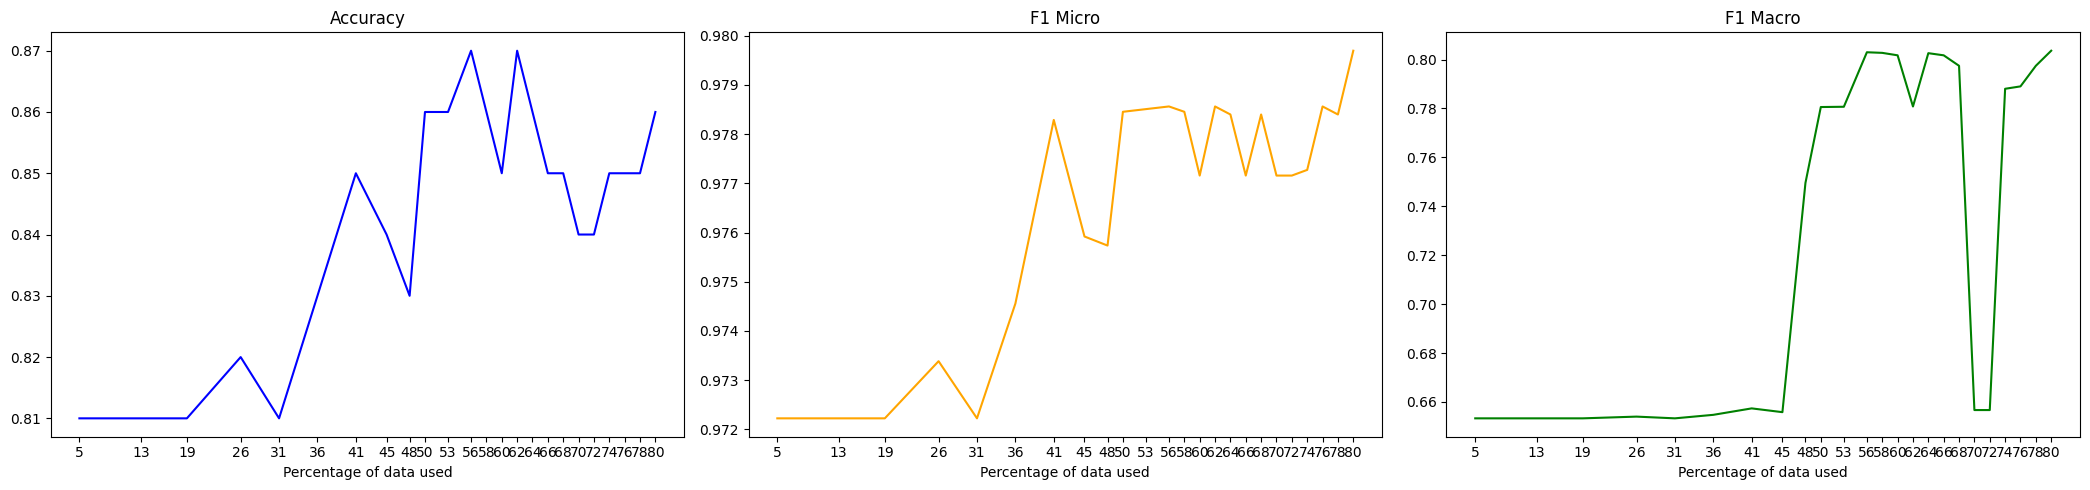

In [18]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.363988,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.269921,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.219893,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.200752,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.187067,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.179119,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.174042,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.171127,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.169264,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.168764,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 25: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.243596088886261
Samples above threshold: 38
Acquired samples: 38
Sampling duration: 3.076557159423828 seconds
New train size: 63


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.270676,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.188555,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.163516,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.157585,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.150121,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.149068,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.146164,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.144309,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.143671,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.143591,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 63: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.16805726289749146
Samples above threshold: 34
Acquired samples: 34
Sampling duration: 2.7649757862091064 seconds
New train size: 97


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.207162,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.160164,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.147694,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.142539,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.137911,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.136572,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.133609,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.132954,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.132618,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.132009,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 97: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.11891160011291504
Samples above threshold: 31
Acquired samples: 31
Sampling duration: 2.4786856174468994 seconds
New train size: 128


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.185025,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.151793,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.142649,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.136485,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.132690,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.129528,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.122131,0.820000,0.964912,0.982143,0.973451,0.654117
8,No log,0.118539,0.820000,0.967337,0.982143,0.974684,0.720656
9,No log,0.115431,0.830000,0.967419,0.984694,0.975980,0.721626
10,No log,0.114905,0.830000,0.967419,0.984694,0.975980,0.765101


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.71      0.72       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.99      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 128: Accuracy: 0.83, F1 Micro: 0.9759797724399494, F1 Macro: 0.7216262471779186
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.25      0.40         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.81      0.71      0.72       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.99      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.02672329545021057
Samples above threshold: 28
Acquired samples: 28
Sampling duration: 2.3023998737335205 seconds
New train size: 156


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.182879,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.153634,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.158365,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.139547,0.780000,0.948655,0.989796,0.968789,0.730207
5,No log,0.134074,0.810000,0.953431,0.992347,0.972500,0.764395
6,No log,0.126765,0.810000,0.953431,0.992347,0.972500,0.764395
7,No log,0.110762,0.830000,0.967419,0.984694,0.975980,0.765101
8,No log,0.109766,0.850000,0.969925,0.987245,0.978508,0.802866
9,No log,0.110691,0.840000,0.965174,0.989796,0.977330,0.788173
10,No log,0.110863,0.850000,0.967581,0.989796,0.978562,0.789034


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 156: Accuracy: 0.85, F1 Micro: 0.978562421185372, F1 Macro: 0.789033565618146
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.89      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.022270166873931886
Samples above threshold: 25
Acquired samples: 25
Sampling duration: 2.0685362815856934 seconds
New train size: 181


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.172381,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.151311,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.142525,0.820000,0.962594,0.984694,0.973518,0.719951
4,No log,0.127777,0.810000,0.957921,0.987245,0.972362,0.736618
5,No log,0.116100,0.810000,0.957921,0.987245,0.972362,0.736618
6,No log,0.114514,0.850000,0.972222,0.982143,0.977157,0.787799
7,No log,0.113192,0.850000,0.965174,0.989796,0.977330,0.796975
8,No log,0.109782,0.830000,0.967419,0.984694,0.975980,0.775805
9,No log,0.109683,0.830000,0.967419,0.984694,0.975980,0.775805
10,No log,0.109794,0.830000,0.967419,0.984694,0.975980,0.775805


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.87      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.79      0.80       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.96      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 181: Accuracy: 0.85, F1 Micro: 0.9773299748110832, F1 Macro: 0.7969745768740744
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.87      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.81      0.79      0.80       392
weighted avg       0.96      0.99      0.97       392
 samples avg       0.96      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.01939924955368042
Samples above threshold: 22
Acquired samples: 22
Sampling duration: 1.9953813552856445 seconds
New train size: 203


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.161782,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.147370,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.131999,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.123895,0.830000,0.960494,0.992347,0.976161,0.759236
5,No log,0.103171,0.850000,0.972222,0.982143,0.977157,0.779593
6,No log,0.104057,0.820000,0.972010,0.974490,0.973248,0.773475
7,No log,0.104696,0.830000,0.965087,0.987245,0.976040,0.766698
8,No log,0.110174,0.840000,0.965174,0.989796,0.977330,0.767681
9,No log,0.101836,0.850000,0.972292,0.984694,0.978454,0.777572
10,No log,0.103483,0.850000,0.967581,0.989796,0.978562,0.777782


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.74      0.83      0.78       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 203: Accuracy: 0.85, F1 Micro: 0.978562421185372, F1 Macro: 0.7777820076815053
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.74      0.83      0.78       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.01731410026550293
Samples above threshold: 20
Acquired samples: 20
Sampling duration: 1.7966313362121582 seconds
New train size: 223


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.161105,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.144434,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.137398,0.810000,0.960199,0.984694,0.972292,0.708840
4,No log,0.112446,0.840000,0.960494,0.992347,0.976161,0.766922
5,No log,0.111874,0.840000,0.960494,0.992347,0.976161,0.766922
6,No log,0.100741,0.840000,0.969773,0.982143,0.975919,0.775678
7,No log,0.104986,0.830000,0.972081,0.977041,0.974555,0.774517
8,No log,0.096865,0.880000,0.974874,0.989796,0.982278,0.805597
9,No log,0.103408,0.860000,0.972292,0.984694,0.978454,0.777572
10,No log,0.102830,0.870000,0.972431,0.989796,0.981037,0.779551


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.78      0.83      0.81       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 223: Accuracy: 0.88, F1 Micro: 0.9822784810126581, F1 Macro: 0.8055974056086349
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.80      1.00      0.89         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.78      0.83      0.81       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.017440116405487063
Samples above threshold: 18
Acquired samples: 18
Sampling duration: 1.603365421295166 seconds
New train size: 241


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.154384,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.139968,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.134769,0.810000,0.960199,0.984694,0.972292,0.708840
4,No log,0.109726,0.830000,0.958128,0.992347,0.974937,0.766071
5,No log,0.104577,0.820000,0.964912,0.982143,0.973451,0.764699
6,No log,0.100381,0.870000,0.974811,0.987245,0.980989,0.822254
7,No log,0.103937,0.820000,0.967254,0.979592,0.973384,0.764559
8,No log,0.110129,0.840000,0.972152,0.979592,0.975858,0.766343
9,No log,0.105364,0.820000,0.967254,0.979592,0.973384,0.764559
10,No log,0.105953,0.820000,0.967337,0.982143,0.974684,0.765577


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      1.00      1.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.83      0.82       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 241: Accuracy: 0.87, F1 Micro: 0.9809885931558936, F1 Macro: 0.8222537267342297
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      1.00      1.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.82      0.83      0.82       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.01579927206039429
Samples above threshold: 16
Acquired samples: 9
Sampling duration: 1.518550157546997 seconds
New train size: 250


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.156719,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.143320,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.124890,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.113838,0.820000,0.960298,0.987245,0.973585,0.737451
5,No log,0.103575,0.830000,0.965000,0.984694,0.974747,0.765704
6,No log,0.106276,0.830000,0.965087,0.987245,0.976040,0.766698
7,No log,0.107165,0.830000,0.965087,0.987245,0.976040,0.766698
8,No log,0.105120,0.860000,0.972292,0.984694,0.978454,0.768369
9,No log,0.103290,0.840000,0.967419,0.984694,0.975980,0.766582
10,No log,0.104031,0.850000,0.967581,0.989796,0.978562,0.768560


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 250: Accuracy: 0.85, F1 Micro: 0.978562421185372, F1 Macro: 0.7685603685715979
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.013283604383468628
Samples above threshold: 15
Acquired samples: 15
Sampling duration: 1.4384102821350098 seconds
New train size: 265


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.159525,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.146183,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.127968,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.107652,0.830000,0.962687,0.987245,0.974811,0.729885
5,No log,0.101267,0.830000,0.965087,0.987245,0.976040,0.747479
6,No log,0.097718,0.840000,0.969849,0.984694,0.977215,0.739903
7,No log,0.097929,0.840000,0.965174,0.989796,0.977330,0.767681
8,No log,0.097957,0.830000,0.962779,0.989796,0.976101,0.767681
9,No log,0.098237,0.830000,0.962779,0.989796,0.976101,0.767681
10,No log,0.096619,0.830000,0.962779,0.989796,0.976101,0.767681


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 265: Accuracy: 0.84, F1 Micro: 0.9773299748110832, F1 Macro: 0.767680997580495
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.012530791759490968
Samples above threshold: 14
Acquired samples: 14
Sampling duration: 1.3299601078033447 seconds
New train size: 279


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.162103,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.138774,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.123617,0.830000,0.965000,0.984694,0.974747,0.720784
4,No log,0.105877,0.840000,0.974555,0.977041,0.975796,0.764699
5,No log,0.106642,0.840000,0.965174,0.989796,0.977330,0.767681
6,No log,0.100169,0.850000,0.967581,0.989796,0.978562,0.777782
7,No log,0.101993,0.840000,0.965174,0.989796,0.977330,0.767681
8,No log,0.100425,0.840000,0.967419,0.984694,0.975980,0.766582
9,No log,0.098088,0.840000,0.967419,0.984694,0.975980,0.766582
10,No log,0.099139,0.850000,0.967500,0.987245,0.977273,0.767577


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.74      0.83      0.78       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 279: Accuracy: 0.85, F1 Micro: 0.978562421185372, F1 Macro: 0.7777820076815053
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.74      0.83      0.78       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.014171361923217773
Samples above threshold: 13
Acquired samples: 13
Sampling duration: 1.195643424987793 seconds
New train size: 292


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.149225,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.135805,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.111991,0.830000,0.965000,0.984694,0.974747,0.720784
4,No log,0.101537,0.850000,0.967581,0.989796,0.978562,0.757542
5,No log,0.099722,0.850000,0.967581,0.989796,0.978562,0.777782
6,No log,0.103247,0.850000,0.965174,0.989796,0.977330,0.776912
7,No log,0.102842,0.840000,0.965174,0.989796,0.977330,0.768560
8,No log,0.098200,0.850000,0.969925,0.987245,0.978508,0.778567
9,No log,0.097701,0.850000,0.969925,0.987245,0.978508,0.778567
10,No log,0.101370,0.850000,0.967581,0.989796,0.978562,0.769450


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.79      0.76       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 292: Accuracy: 0.85, F1 Micro: 0.978562421185372, F1 Macro: 0.7575418529109638
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      0.75      0.60         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.79      0.76       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.016290551424026488
Samples above threshold: 11
Acquired samples: 8
Sampling duration: 1.1857450008392334 seconds
New train size: 300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.149215,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.146132,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.127124,0.780000,0.948655,0.989796,0.968789,0.725546
4,No log,0.109307,0.830000,0.965000,0.984694,0.974747,0.765704
5,No log,0.093947,0.850000,0.974619,0.979592,0.977099,0.779466
6,No log,0.099043,0.860000,0.967662,0.992347,0.979849,0.778754
7,No log,0.098729,0.840000,0.969849,0.984694,0.977215,0.767471
8,No log,0.102792,0.820000,0.969697,0.979592,0.974619,0.765446
9,No log,0.098383,0.840000,0.969849,0.984694,0.977215,0.767471
10,No log,0.098557,0.840000,0.969849,0.984694,0.977215,0.767471


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.74      0.83      0.78       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 300: Accuracy: 0.86, F1 Micro: 0.9798488664987406, F1 Macro: 0.7787539741230849
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.74      0.83      0.78       392
weighted avg       0.96      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 0.015110057592391968
Samples above threshold: 10
Acquired samples: 10
Sampling duration: 1.098292589187622 seconds
New train size: 310


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.151225,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.139849,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.111493,0.840000,0.972222,0.982143,0.977157,0.750825
4,No log,0.101622,0.830000,0.965000,0.984694,0.974747,0.758035
5,No log,0.100098,0.850000,0.967581,0.989796,0.978562,0.768560
6,No log,0.104014,0.800000,0.974359,0.969388,0.971867,0.763051
7,No log,0.092580,0.870000,0.977157,0.982143,0.979644,0.789584
8,No log,0.097269,0.850000,0.967581,0.989796,0.978562,0.768560
9,No log,0.098645,0.850000,0.967581,0.989796,0.978562,0.769450
10,No log,0.095270,0.850000,0.967581,0.989796,0.978562,0.769450


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.95      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 310: Accuracy: 0.87, F1 Micro: 0.9796437659033078, F1 Macro: 0.7895839350006738
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.93      0.95      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 0.011771863698959353
Samples above threshold: 9
Acquired samples: 10
Sampling duration: 1.0307650566101074 seconds
New train size: 320


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.148372,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.134590,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.132577,0.790000,0.948780,0.992347,0.970075,0.743006
4,No log,0.097949,0.850000,0.972292,0.984694,0.978454,0.766811
5,No log,0.100196,0.820000,0.972010,0.974490,0.973248,0.764270
6,No log,0.097172,0.850000,0.967581,0.989796,0.978562,0.768560
7,No log,0.102589,0.850000,0.969925,0.987245,0.978508,0.768466
8,No log,0.101183,0.840000,0.967500,0.987245,0.977273,0.767577
9,No log,0.094970,0.850000,0.969925,0.987245,0.978508,0.777678
10,No log,0.097034,0.840000,0.967500,0.987245,0.977273,0.767577


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 320: Accuracy: 0.85, F1 Micro: 0.978562421185372, F1 Macro: 0.7685603685715979
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 0.011522722244262696
Samples above threshold: 8
Acquired samples: 10
Sampling duration: 0.926081657409668 seconds
New train size: 330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.143810,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.127258,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.111994,0.820000,0.955774,0.992347,0.973717,0.765229
4,No log,0.096058,0.840000,0.974555,0.977041,0.975796,0.778448
5,No log,0.110635,0.850000,0.965174,0.989796,0.977330,0.779960
6,No log,0.094726,0.830000,0.976923,0.971939,0.974425,0.785437
7,No log,0.096581,0.870000,0.972431,0.989796,0.981037,0.790783
8,No log,0.094475,0.850000,0.972222,0.982143,0.977157,0.788686
9,No log,0.094122,0.850000,0.972222,0.982143,0.977157,0.788686
10,No log,0.096212,0.840000,0.969773,0.982143,0.975919,0.787799


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 330: Accuracy: 0.87, F1 Micro: 0.9810366624525917, F1 Macro: 0.7907825907938201
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 0.0100092351436615
Samples above threshold: 7
Acquired samples: 10
Sampling duration: 0.8700742721557617 seconds
New train size: 340


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.149070,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.129037,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.108121,0.840000,0.972222,0.982143,0.977157,0.656672
4,No log,0.113284,0.830000,0.958128,0.992347,0.974937,0.766071
5,No log,0.093050,0.830000,0.981865,0.966837,0.974293,0.763215
6,No log,0.097415,0.850000,0.967581,0.989796,0.978562,0.768560
7,No log,0.092658,0.860000,0.972292,0.984694,0.978454,0.777572
8,No log,0.096315,0.850000,0.969925,0.987245,0.978508,0.768466
9,No log,0.093741,0.840000,0.972222,0.982143,0.977157,0.767362
10,No log,0.094017,0.850000,0.969925,0.987245,0.978508,0.768466


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 340: Accuracy: 0.85, F1 Micro: 0.978562421185372, F1 Macro: 0.7685603685715979
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 0.010367149114608764
Samples above threshold: 6
Acquired samples: 10
Sampling duration: 0.8359906673431396 seconds
New train size: 350


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.143184,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.135261,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.118991,0.790000,0.948780,0.992347,0.970075,0.743006
4,No log,0.091254,0.850000,0.972292,0.984694,0.978454,0.751808
5,No log,0.093455,0.860000,0.970000,0.989796,0.979798,0.778661
6,No log,0.094494,0.810000,0.976923,0.971939,0.974425,0.765035
7,No log,0.092033,0.860000,0.972292,0.984694,0.978454,0.768369
8,No log,0.098280,0.850000,0.974684,0.982143,0.978399,0.768270
9,No log,0.096068,0.850000,0.969925,0.987245,0.978508,0.777678
10,No log,0.094633,0.860000,0.972362,0.987245,0.979747,0.778567


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 350: Accuracy: 0.86, F1 Micro: 0.9797979797979798, F1 Macro: 0.778661378672608
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 0.010413849353790283
Samples above threshold: 5
Acquired samples: 10
Sampling duration: 0.7388193607330322 seconds
New train size: 360


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142873,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.130018,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.116564,0.810000,0.955665,0.989796,0.972431,0.745027
4,No log,0.095267,0.850000,0.977041,0.977041,0.977041,0.796305
5,No log,0.101318,0.840000,0.965087,0.987245,0.976040,0.759030
6,No log,0.093532,0.820000,0.969620,0.977041,0.973316,0.764416
7,No log,0.097409,0.840000,0.967500,0.987245,0.977273,0.767577
8,No log,0.093536,0.850000,0.972292,0.984694,0.978454,0.788805
9,No log,0.094898,0.820000,0.967254,0.979592,0.973384,0.764559
10,No log,0.095394,0.830000,0.967419,0.984694,0.975980,0.766582


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 360: Accuracy: 0.85, F1 Micro: 0.9784537389100126, F1 Macro: 0.7888046636194153
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 0.009223014116287231
Samples above threshold: 4
Acquired samples: 10
Sampling duration: 0.639265775680542 seconds
New train size: 370


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142082,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.130941,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.103268,0.830000,0.967419,0.984694,0.975980,0.750078
4,No log,0.100794,0.840000,0.967419,0.984694,0.975980,0.766582
5,No log,0.092573,0.850000,0.969925,0.987245,0.978508,0.777678
6,No log,0.085603,0.860000,0.982005,0.974490,0.978233,0.797058
7,No log,0.097598,0.850000,0.967581,0.989796,0.978562,0.777782
8,No log,0.092182,0.860000,0.972362,0.987245,0.979747,0.789799
9,No log,0.091569,0.860000,0.972362,0.987245,0.979747,0.789799
10,No log,0.093103,0.850000,0.969925,0.987245,0.978508,0.788920


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 370: Accuracy: 0.86, F1 Micro: 0.979746835443038, F1 Macro: 0.7897991831818266
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 0.007746469974517822
Samples above threshold: 3
Acquired samples: 10
Sampling duration: 0.5325510501861572 seconds
New train size: 380


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.141380,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.126560,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.106167,0.820000,0.967254,0.979592,0.973384,0.745375
4,No log,0.093854,0.840000,0.967419,0.984694,0.975980,0.750078
5,No log,0.100850,0.830000,0.960396,0.989796,0.974874,0.765951
6,No log,0.098474,0.840000,0.965087,0.987245,0.976040,0.766698
7,No log,0.095333,0.840000,0.972152,0.979592,0.975858,0.775547
8,No log,0.095688,0.860000,0.972292,0.984694,0.978454,0.789693
9,No log,0.100543,0.850000,0.969925,0.987245,0.978508,0.778567
10,No log,0.100310,0.840000,0.967500,0.987245,0.977273,0.768466


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 380: Accuracy: 0.85, F1 Micro: 0.9785082174462705, F1 Macro: 0.7785666906695781
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 0.0072564780712127686
Samples above threshold: 2
Acquired samples: 10
Sampling duration: 0.44000959396362305 seconds
New train size: 390


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142779,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.130653,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.104469,0.840000,0.967419,0.984694,0.975980,0.711366
4,No log,0.096837,0.840000,0.962779,0.989796,0.976101,0.766811
5,No log,0.090564,0.870000,0.979592,0.979592,0.979592,0.798210
6,No log,0.093718,0.860000,0.972362,0.987245,0.979747,0.778567
7,No log,0.099857,0.850000,0.967500,0.987245,0.977273,0.767577
8,No log,0.103079,0.840000,0.967419,0.984694,0.975980,0.767471
9,No log,0.101287,0.830000,0.965000,0.984694,0.974747,0.766582
10,No log,0.099200,0.840000,0.967419,0.984694,0.975980,0.767471


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 390: Accuracy: 0.86, F1 Micro: 0.979746835443038, F1 Macro: 0.7785666906695781
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 0.0087444007396698
Samples above threshold: 1
Acquired samples: 10
Sampling duration: 0.35260009765625 seconds
New train size: 400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.143012,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.125758,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.110936,0.840000,0.965174,0.989796,0.977330,0.760013
4,No log,0.096817,0.840000,0.965174,0.989796,0.977330,0.767681
5,No log,0.092455,0.840000,0.967500,0.987245,0.977273,0.767577
6,No log,0.113984,0.850000,0.967581,0.989796,0.978562,0.768560
7,No log,0.107297,0.840000,0.967500,0.987245,0.977273,0.767577
8,No log,0.104792,0.840000,0.967500,0.987245,0.977273,0.767577
9,No log,0.103787,0.850000,0.969925,0.987245,0.978508,0.777678
10,0.097400,0.101059,0.850000,0.969925,0.987245,0.978508,0.777678


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 400: Accuracy: 0.85, F1 Micro: 0.978562421185372, F1 Macro: 0.7685603685715979
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392

Total sampling time: 32.22 seconds
Total runtime: 2672.469328403473 seconds


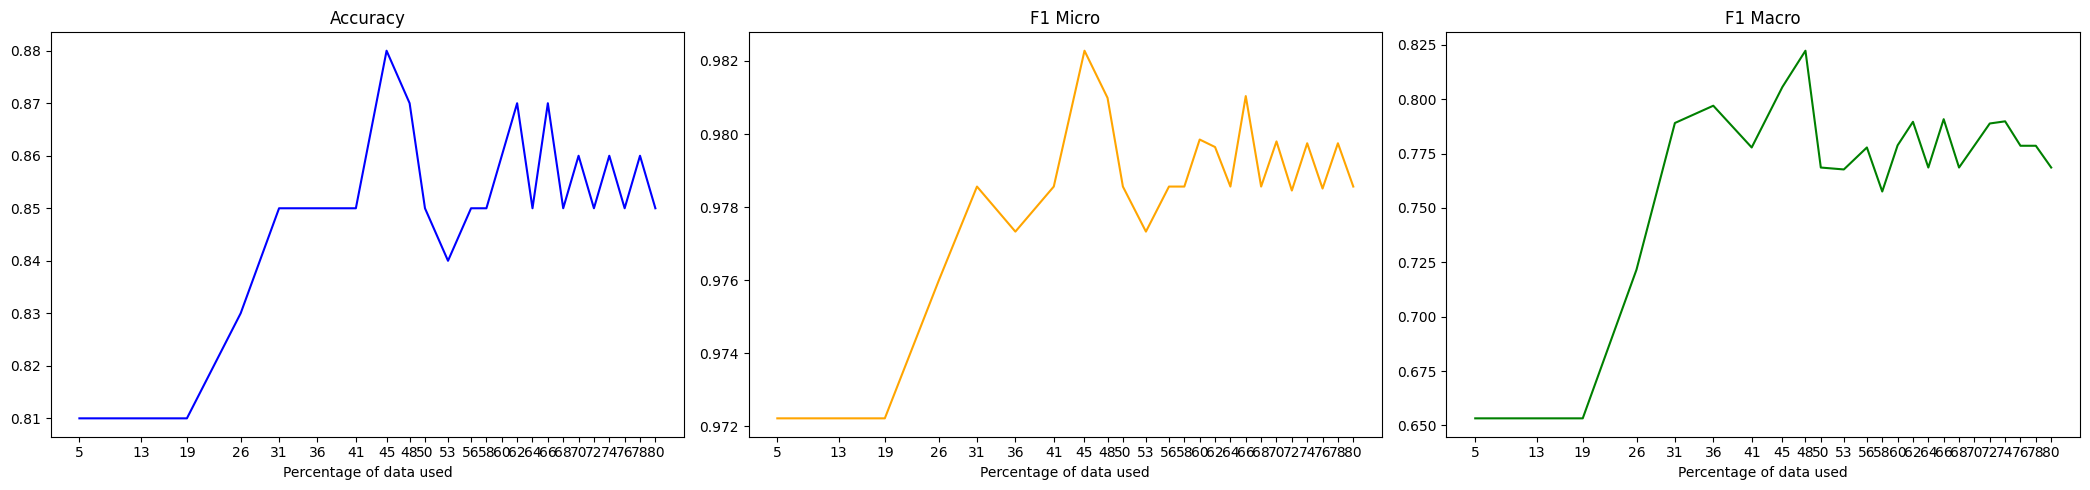

In [19]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.380765,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.275398,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.239973,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.220720,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.202465,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.190056,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.182793,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.178994,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.177267,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.177220,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 25: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.2863384962081909
Samples above threshold: 38
Acquired samples: 38
Sampling duration: 3.006359815597534 seconds
New train size: 63


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.285259,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.189725,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.162868,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.151770,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.145951,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.141996,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.139723,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.139021,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.138682,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.139016,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 63: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.16826333999633789
Samples above threshold: 34
Acquired samples: 34
Sampling duration: 2.7511746883392334 seconds
New train size: 97


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.211378,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.158464,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.144968,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.138610,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.133724,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.133726,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.132489,0.810000,0.962500,0.982143,0.972222,0.653284
8,No log,0.126358,0.810000,0.962500,0.982143,0.972222,0.653284
9,No log,0.127641,0.810000,0.962500,0.982143,0.972222,0.653284
10,No log,0.127035,0.810000,0.962500,0.982143,0.972222,0.653284


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 97: Accuracy: 0.81, F1 Micro: 0.9722222222222222, F1 Macro: 0.6532843428612597
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.86      1.00      0.92        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.96      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.96       392
 samples avg       0.96      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.0914685845375061
Samples above threshold: 31
Acquired samples: 31
Sampling duration: 2.528757333755493 seconds
New train size: 128


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.187994,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.149434,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.140119,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.133004,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.130988,0.810000,0.962500,0.982143,0.972222,0.653284
6,No log,0.134278,0.810000,0.962500,0.982143,0.972222,0.653284
7,No log,0.127353,0.820000,0.967337,0.982143,0.974684,0.654960
8,No log,0.123276,0.820000,0.967337,0.982143,0.974684,0.654960
9,No log,0.122652,0.820000,0.967337,0.982143,0.974684,0.654960
10,No log,0.122430,0.820000,0.967337,0.982143,0.974684,0.654960


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 128: Accuracy: 0.82, F1 Micro: 0.9746835443037974, F1 Macro: 0.6549595805112519
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.88      1.00      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.97       392
   macro avg       0.64      0.67      0.65       392
weighted avg       0.95      0.98      0.97       392
 samples avg       0.97      0.98      0.97       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.015533739328384399
Samples above threshold: 28
Acquired samples: 28
Sampling duration: 2.268573045730591 seconds
New train size: 156


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.172203,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.143468,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.136271,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.134497,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.121809,0.830000,0.969773,0.982143,0.975919,0.655811
6,No log,0.118217,0.840000,0.972222,0.982143,0.977157,0.656672
7,No log,0.121135,0.830000,0.974490,0.974490,0.974490,0.654593
8,No log,0.121213,0.830000,0.969773,0.982143,0.975919,0.655811
9,No log,0.118928,0.840000,0.972222,0.982143,0.977157,0.656672
10,No log,0.118506,0.840000,0.972222,0.982143,0.977157,0.656672


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 156: Accuracy: 0.84, F1 Micro: 0.9771573604060914, F1 Macro: 0.6566716365711341
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.018097263574600224
Samples above threshold: 25
Acquired samples: 25
Sampling duration: 2.1096243858337402 seconds
New train size: 181


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.160731,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.138113,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.129748,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.124153,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.119501,0.820000,0.967337,0.982143,0.974684,0.654960
6,No log,0.116820,0.830000,0.972152,0.979592,0.975858,0.655700
7,No log,0.119620,0.840000,0.972222,0.982143,0.977157,0.656672
8,No log,0.120229,0.830000,0.972152,0.979592,0.975858,0.655700
9,No log,0.120912,0.840000,0.972222,0.982143,0.977157,0.656672
10,No log,0.120532,0.830000,0.972152,0.979592,0.975858,0.655700


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 181: Accuracy: 0.84, F1 Micro: 0.9771573604060914, F1 Macro: 0.6566716365711341
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.01632518768310547
Samples above threshold: 22
Acquired samples: 22
Sampling duration: 1.9341297149658203 seconds
New train size: 203


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.159266,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.137014,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.129145,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.123256,0.810000,0.962500,0.982143,0.972222,0.653284
5,No log,0.114956,0.840000,0.972222,0.982143,0.977157,0.656672
6,No log,0.115319,0.840000,0.972222,0.982143,0.977157,0.656672
7,No log,0.111274,0.840000,0.972222,0.982143,0.977157,0.656672
8,No log,0.114252,0.850000,0.974684,0.982143,0.978399,0.657542
9,No log,0.108595,0.830000,0.974555,0.977041,0.975796,0.655587
10,No log,0.109050,0.850000,0.974684,0.982143,0.978399,0.657542


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 203: Accuracy: 0.85, F1 Micro: 0.9783989834815755, F1 Macro: 0.6575418529109637
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      1.00      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.65      0.67      0.66       392
weighted avg       0.96      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.013634502887725832
Samples above threshold: 20
Acquired samples: 20
Sampling duration: 1.7607078552246094 seconds
New train size: 223


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.152414,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.139496,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.124715,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.120052,0.840000,0.974555,0.977041,0.975796,0.655587
5,No log,0.116605,0.830000,0.969773,0.982143,0.975919,0.655811
6,No log,0.106238,0.840000,0.974619,0.979592,0.977099,0.722254
7,No log,0.106426,0.840000,0.969773,0.982143,0.975919,0.721507
8,No log,0.105476,0.860000,0.974747,0.984694,0.979695,0.767681
9,No log,0.101397,0.850000,0.974684,0.982143,0.978399,0.723237
10,No log,0.100811,0.850000,0.974684,0.982143,0.978399,0.766698


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 223: Accuracy: 0.86, F1 Micro: 0.9796954314720812, F1 Macro: 0.767680997580495
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.013593447208404542
Samples above threshold: 18
Acquired samples: 18
Sampling duration: 1.661163568496704 seconds
New train size: 241


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.157489,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.132866,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.122160,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.118519,0.850000,0.967500,0.987245,0.977273,0.766071
5,No log,0.104553,0.870000,0.979644,0.982143,0.980892,0.768466
6,No log,0.105164,0.820000,0.979328,0.966837,0.973042,0.762320
7,No log,0.102892,0.840000,0.969849,0.984694,0.977215,0.731523
8,No log,0.106156,0.850000,0.967581,0.989796,0.978562,0.768560
9,No log,0.105664,0.830000,0.969773,0.982143,0.975919,0.755471
10,No log,0.102970,0.820000,0.969697,0.979592,0.974619,0.729545


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 241: Accuracy: 0.87, F1 Micro: 0.9808917197452229, F1 Macro: 0.7684656805685678
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.98      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 250
Threshold: 0.01491401195526123
Samples above threshold: 16
Acquired samples: 9
Sampling duration: 1.523240089416504 seconds
New train size: 250


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.155812,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.142323,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.123418,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.116913,0.810000,0.957921,0.987245,0.972362,0.744899
5,No log,0.122460,0.810000,0.964824,0.979592,0.972152,0.756012
6,No log,0.113179,0.840000,0.965087,0.987245,0.976040,0.759030
7,No log,0.099777,0.860000,0.974684,0.982143,0.978399,0.780471
8,No log,0.103781,0.860000,0.972362,0.987245,0.979747,0.768560
9,No log,0.100193,0.860000,0.969925,0.987245,0.978508,0.780700
10,No log,0.098898,0.860000,0.974747,0.984694,0.979695,0.781466


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 250: Accuracy: 0.86, F1 Micro: 0.979746835443038, F1 Macro: 0.7685603685715979
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.011583507061004639
Samples above threshold: 15
Acquired samples: 15
Sampling duration: 1.4516234397888184 seconds
New train size: 265


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.149516,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.144424,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.128883,0.820000,0.967337,0.982143,0.974684,0.654960
4,No log,0.124041,0.820000,0.960298,0.987245,0.973585,0.729034
5,No log,0.107186,0.780000,0.971722,0.964286,0.967990,0.724217
6,No log,0.100883,0.850000,0.972222,0.982143,0.977157,0.766582
7,No log,0.100894,0.860000,0.972362,0.987245,0.979747,0.768560
8,No log,0.097874,0.850000,0.974684,0.982143,0.978399,0.780471
9,No log,0.097693,0.840000,0.974619,0.979592,0.977099,0.779466
10,No log,0.100760,0.830000,0.967419,0.984694,0.975980,0.747375


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 265: Accuracy: 0.86, F1 Micro: 0.979746835443038, F1 Macro: 0.7685603685715979
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.010708260536193847
Samples above threshold: 14
Acquired samples: 14
Sampling duration: 1.3472788333892822 seconds
New train size: 279


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.150121,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.132928,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.129525,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.102152,0.860000,0.974747,0.984694,0.979695,0.781466
5,No log,0.109155,0.820000,0.962687,0.987245,0.974811,0.746609
6,No log,0.105556,0.820000,0.967337,0.982143,0.974684,0.746380
7,No log,0.098691,0.840000,0.974619,0.979592,0.977099,0.779466
8,No log,0.102645,0.830000,0.972152,0.979592,0.975858,0.765577
9,No log,0.102137,0.820000,0.969697,0.979592,0.974619,0.754466
10,No log,0.099562,0.830000,0.972152,0.979592,0.975858,0.765577


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 279: Accuracy: 0.86, F1 Micro: 0.9796954314720812, F1 Macro: 0.7814658498484933
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.013714134693145752
Samples above threshold: 13
Acquired samples: 13
Sampling duration: 1.2783870697021484 seconds
New train size: 292


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.149998,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.136487,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.124917,0.840000,0.972222,0.982143,0.977157,0.656672
4,No log,0.113863,0.790000,0.967005,0.971939,0.969466,0.719086
5,No log,0.101554,0.820000,0.976864,0.969388,0.973111,0.762489
6,No log,0.100647,0.860000,0.974747,0.984694,0.979695,0.767681
7,No log,0.100768,0.850000,0.974684,0.982143,0.978399,0.780471
8,No log,0.104110,0.840000,0.969849,0.984694,0.977215,0.776683
9,No log,0.099852,0.820000,0.972081,0.977041,0.974555,0.764559
10,No log,0.100004,0.850000,0.972292,0.984694,0.978454,0.788805


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 292: Accuracy: 0.86, F1 Micro: 0.9796954314720812, F1 Macro: 0.767680997580495
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.50      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.90      0.99      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.82      0.75      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 300
Threshold: 0.011740940809249877
Samples above threshold: 11
Acquired samples: 8
Sampling duration: 1.1850769519805908 seconds
New train size: 300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.144720,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.128174,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.130766,0.830000,0.972152,0.979592,0.975858,0.655700
4,No log,0.102306,0.850000,0.974684,0.982143,0.978399,0.751704
5,No log,0.106109,0.790000,0.967005,0.971939,0.969466,0.742287
6,No log,0.106932,0.800000,0.967089,0.974490,0.970775,0.743328
7,No log,0.099055,0.860000,0.977157,0.982143,0.979644,0.798328
8,No log,0.103916,0.840000,0.967500,0.987245,0.977273,0.748358
9,No log,0.099712,0.820000,0.972081,0.977041,0.974555,0.764559
10,No log,0.101164,0.830000,0.972152,0.979592,0.975858,0.765577


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 300: Accuracy: 0.86, F1 Micro: 0.9796437659033078, F1 Macro: 0.7983284731432249
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.79      0.80       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 0.009245437383651734
Samples above threshold: 10
Acquired samples: 10
Sampling duration: 1.0933253765106201 seconds
New train size: 310


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.147806,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.126364,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.115654,0.820000,0.964912,0.982143,0.973451,0.654117
4,No log,0.112451,0.790000,0.962406,0.979592,0.970923,0.736921
5,No log,0.105505,0.790000,0.969388,0.969388,0.969388,0.742118
6,No log,0.105995,0.790000,0.967005,0.971939,0.969466,0.735597
7,No log,0.098372,0.810000,0.969620,0.977041,0.973316,0.745244
8,No log,0.095340,0.830000,0.969773,0.982143,0.975919,0.755471
9,No log,0.098277,0.840000,0.969849,0.984694,0.977215,0.776683
10,No log,0.096939,0.830000,0.969773,0.982143,0.975919,0.775678


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 310: Accuracy: 0.84, F1 Micro: 0.9772151898734177, F1 Macro: 0.7766834514982032
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.57      1.00      0.73         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.83      0.78       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.97      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 0.007768899202346803
Samples above threshold: 9
Acquired samples: 10
Sampling duration: 1.0146205425262451 seconds
New train size: 320


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.145960,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.130853,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.114992,0.830000,0.967337,0.982143,0.974684,0.654960
4,No log,0.113739,0.830000,0.962687,0.987245,0.974811,0.738293
5,No log,0.123440,0.780000,0.962121,0.971939,0.967005,0.745563
6,No log,0.098944,0.850000,0.977099,0.979592,0.978344,0.797323
7,No log,0.100266,0.850000,0.969849,0.984694,0.977215,0.756466
8,No log,0.103535,0.850000,0.969849,0.984694,0.977215,0.756466
9,No log,0.105293,0.810000,0.964824,0.979592,0.972152,0.737799
10,No log,0.101910,0.830000,0.969773,0.982143,0.975919,0.755471


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.78      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 320: Accuracy: 0.85, F1 Micro: 0.9783439490445859, F1 Macro: 0.7973226522221498
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.78      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 0.009568768739700318
Samples above threshold: 8
Acquired samples: 10
Sampling duration: 0.9733359813690186 seconds
New train size: 330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.139994,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.127191,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.112312,0.830000,0.974555,0.977041,0.975796,0.655587
4,No log,0.100418,0.830000,0.979381,0.969388,0.974359,0.763374
5,No log,0.098574,0.830000,0.969697,0.979592,0.974619,0.746262
6,No log,0.097407,0.850000,0.977099,0.979592,0.978344,0.797323
7,No log,0.101782,0.800000,0.971867,0.969388,0.970626,0.751209
8,No log,0.100860,0.830000,0.967419,0.984694,0.975980,0.766582
9,No log,0.101092,0.830000,0.969773,0.982143,0.975919,0.755471
10,No log,0.098490,0.850000,0.974684,0.982143,0.978399,0.767471


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 330: Accuracy: 0.85, F1 Micro: 0.9783989834815755, F1 Macro: 0.7674705598700573
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.92      0.97      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 0.006793683767318726
Samples above threshold: 7
Acquired samples: 10
Sampling duration: 0.9154906272888184 seconds
New train size: 340


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.139808,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.126218,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.112165,0.830000,0.974555,0.977041,0.975796,0.655587
4,No log,0.104888,0.830000,0.967419,0.984694,0.975980,0.739034
5,No log,0.104990,0.820000,0.967254,0.979592,0.973384,0.745375
6,No log,0.105683,0.860000,0.977099,0.979592,0.978344,0.797323
7,No log,0.105221,0.820000,0.967337,0.982143,0.974684,0.746380
8,No log,0.107124,0.820000,0.965000,0.984694,0.974747,0.739799
9,No log,0.102583,0.830000,0.969773,0.982143,0.975919,0.755471
10,No log,0.100966,0.830000,0.969773,0.982143,0.975919,0.755471


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.78      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 340: Accuracy: 0.86, F1 Micro: 0.9783439490445859, F1 Macro: 0.7973226522221498
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       1.00      0.75      0.86         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.95      0.93        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.98      0.98      0.98       392
   macro avg       0.82      0.78      0.80       392
weighted avg       0.97      0.98      0.97       392
 samples avg       0.98      0.98      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 350
Threshold: 0.009527558088302612
Samples above threshold: 6
Acquired samples: 10
Sampling duration: 0.7875726222991943 seconds
New train size: 350


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.144264,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.123295,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.108564,0.840000,0.974619,0.979592,0.977099,0.656570
4,No log,0.107319,0.830000,0.967419,0.984694,0.975980,0.724116
5,No log,0.101026,0.820000,0.969620,0.977041,0.973316,0.745244
6,No log,0.110144,0.850000,0.967581,0.989796,0.978562,0.768560
7,No log,0.102160,0.830000,0.969697,0.979592,0.974619,0.765446
8,No log,0.099109,0.830000,0.969773,0.982143,0.975919,0.755471
9,No log,0.101435,0.850000,0.972292,0.984694,0.978454,0.777572
10,No log,0.100981,0.840000,0.972222,0.982143,0.977157,0.756359


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 350: Accuracy: 0.85, F1 Micro: 0.978562421185372, F1 Macro: 0.7685603685715979
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 0.008079147338867188
Samples above threshold: 5
Acquired samples: 10
Sampling duration: 0.7371485233306885 seconds
New train size: 360


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.142304,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.133854,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.110055,0.830000,0.974555,0.977041,0.975796,0.655587
4,No log,0.106536,0.800000,0.967089,0.974490,0.970775,0.762489
5,No log,0.098776,0.820000,0.969697,0.979592,0.974619,0.754466
6,No log,0.101492,0.810000,0.967254,0.979592,0.973384,0.745375
7,No log,0.102036,0.800000,0.967089,0.974490,0.970775,0.743328
8,No log,0.102912,0.840000,0.967500,0.987245,0.977273,0.767577
9,No log,0.100717,0.830000,0.967419,0.984694,0.975980,0.747375
10,No log,0.099515,0.830000,0.967419,0.984694,0.975980,0.747375


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 360: Accuracy: 0.84, F1 Micro: 0.9772727272727273, F1 Macro: 0.7675769609596045
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.50      1.00      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.73      0.83      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 0.006304383277893066
Samples above threshold: 4
Acquired samples: 10
Sampling duration: 0.652350664138794 seconds
New train size: 370


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.138781,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.142857,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.120614,0.810000,0.962500,0.982143,0.972222,0.653284
4,No log,0.095400,0.850000,0.974684,0.982143,0.978399,0.751704
5,No log,0.094743,0.820000,0.967337,0.982143,0.974684,0.746380
6,No log,0.097909,0.850000,0.969925,0.987245,0.978508,0.757449
7,No log,0.091654,0.860000,0.974747,0.984694,0.979695,0.781466
8,No log,0.097224,0.840000,0.969849,0.984694,0.977215,0.756466
9,No log,0.092079,0.850000,0.972292,0.984694,0.978454,0.767577
10,No log,0.096424,0.840000,0.969849,0.984694,0.977215,0.756466


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 370: Accuracy: 0.86, F1 Micro: 0.9796954314720812, F1 Macro: 0.7814658498484933
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.98      0.94        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.98      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 0.006306999921798707
Samples above threshold: 3
Acquired samples: 10
Sampling duration: 0.5250997543334961 seconds
New train size: 380


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.141315,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.125577,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.112584,0.830000,0.976923,0.971939,0.974425,0.654466
4,No log,0.106173,0.830000,0.969773,0.982143,0.975919,0.730540
5,No log,0.101860,0.860000,0.972362,0.987245,0.979747,0.768560
6,No log,0.099289,0.830000,0.972152,0.979592,0.975858,0.765577
7,No log,0.099966,0.860000,0.972362,0.987245,0.979747,0.768560
8,No log,0.098327,0.860000,0.972362,0.987245,0.979747,0.768560
9,No log,0.097892,0.860000,0.972362,0.987245,0.979747,0.768560
10,No log,0.098882,0.850000,0.969925,0.987245,0.978508,0.757449


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 380: Accuracy: 0.86, F1 Micro: 0.979746835443038, F1 Macro: 0.7685603685715979
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.60      0.75      0.67         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.75      0.79      0.77       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 0.0073227941989898685
Samples above threshold: 2
Acquired samples: 10
Sampling duration: 0.44287896156311035 seconds
New train size: 390


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.143299,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.132466,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.115040,0.830000,0.972152,0.979592,0.975858,0.655700
4,No log,0.108420,0.810000,0.971939,0.971939,0.971939,0.735753
5,No log,0.101055,0.840000,0.969773,0.982143,0.975919,0.730540
6,No log,0.102368,0.840000,0.967500,0.987245,0.977273,0.748358
7,No log,0.114394,0.820000,0.962500,0.982143,0.972222,0.749704
8,No log,0.095797,0.870000,0.974811,0.987245,0.980989,0.782449
9,No log,0.093566,0.860000,0.974747,0.984694,0.979695,0.781466
10,No log,0.093852,0.860000,0.972362,0.987245,0.979747,0.768560


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 390: Accuracy: 0.87, F1 Micro: 0.9809885931558936, F1 Macro: 0.7824492574604868
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.75      0.75      0.75         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.78      0.79      0.78       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.98      0.99      0.98       392



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 400
Threshold: 0.005423527956008911
Samples above threshold: 1
Acquired samples: 10
Sampling duration: 0.3690190315246582 seconds
New train size: 400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.136446,0.810000,0.962500,0.982143,0.972222,0.653284
2,No log,0.125385,0.810000,0.962500,0.982143,0.972222,0.653284
3,No log,0.117916,0.820000,0.979328,0.966837,0.973042,0.653305
4,No log,0.101357,0.840000,0.962779,0.989796,0.976101,0.755811
5,No log,0.095769,0.860000,0.974684,0.982143,0.978399,0.780471
6,No log,0.101008,0.820000,0.964912,0.982143,0.973451,0.757030
7,No log,0.097060,0.850000,0.972292,0.984694,0.978454,0.767577
8,No log,0.094242,0.860000,0.972362,0.987245,0.979747,0.768560
9,No log,0.096613,0.870000,0.972431,0.989796,0.981037,0.790783
10,0.099900,0.094377,0.870000,0.972431,0.989796,0.981037,0.790783


Trainer is attempting to log a value of "              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 400: Accuracy: 0.87, F1 Micro: 0.9810366624525917, F1 Macro: 0.7907825907938201
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       100
        2-GI       0.67      1.00      0.80         4
        3-PI       1.00      1.00      1.00       100
        4-DM       0.91      0.99      0.95        86
     5-EDTRB       0.99      1.00      0.99        99
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.99      0.98       392
   macro avg       0.76      0.83      0.79       392
weighted avg       0.97      0.99      0.98       392
 samples avg       0.97      0.99      0.98       392

Total sampling time: 32.32 seconds
Total runtime: 2713.209583759308 seconds


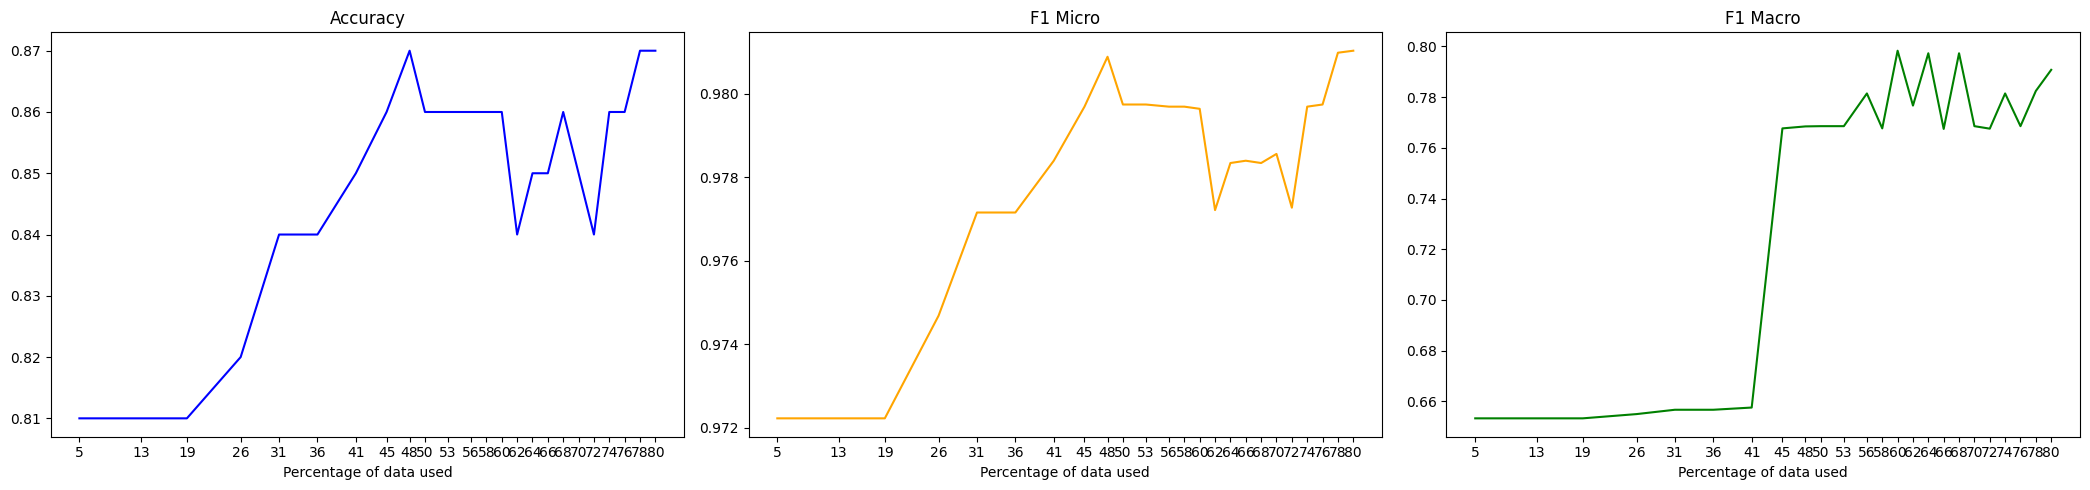

In [20]:
active_learning(seeds[4], 4)